In [1]:
!pip install jupyter_contrib_nbextensions
!jupyter contrib nbextension install --user 
!jupyter nbextension enable codefolding/main
!python -m pip install -U notebook-as-pdf
!pyppeteer-install
!jupyter-nbconvert stats_model_Mercury.ipynb --no-input --no-prompt --to html

[I 17:47:33 InstallContribNbextensionsApp] jupyter contrib nbextension install --user
[I 17:47:33 InstallContribNbextensionsApp] Installing jupyter_contrib_nbextensions nbextension files to jupyter data directory
[I 17:47:33 InstallContribNbextensionsApp] Installing /usr/local/lib/python3.8/dist-packages/jupyter_contrib_nbextensions/nbextensions/scratchpad -> scratchpad
[I 17:47:33 InstallContribNbextensionsApp] Up to date: /root/.local/share/jupyter/nbextensions/scratchpad/LICENSE
[I 17:47:33 InstallContribNbextensionsApp] Up to date: /root/.local/share/jupyter/nbextensions/scratchpad/README.md
[I 17:47:33 InstallContribNbextensionsApp] Up to date: /root/.local/share/jupyter/nbextensions/scratchpad/scratchpad.yaml
[I 17:47:33 InstallContribNbextensionsApp] Up to date: /root/.local/share/jupyter/nbextensions/scratchpad/scratchpad.css
[I 17:47:33 InstallContribNbextensionsApp] Up to date: /root/.local/share/jupyter/nbextensions/scratchpad/main.js
[I 17:47:33 InstallContribNbextensionsAp

# FUNCTIONS

In [2]:
from typing import Tuple
import seaborn as sns
import pandas as pd
import numpy as np
import random 
import matplotlib.pyplot as plt
from scipy.stats import describe, pearsonr, zscore, f_oneway, yeojohnson, shapiro, probplot, levene
import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.stats.anova import anova_lm

from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import SelectFromModel
pd.options.mode.chained_assignment = None

def anova_table(aov):
    aov['mean_sq'] = aov[:]['sum_sq']/aov[:]['df']

    aov['eta_sq'] = aov[:-1]['sum_sq']/sum(aov['sum_sq'])

    aov['omega_sq'] = (aov[:-1]['sum_sq']-(aov[:-1]['df']*aov['mean_sq'][-1]))/(sum(aov['sum_sq'])+aov['mean_sq'][-1])

    cols = ['sum_sq', 'df', 'mean_sq', 'F', 'PR(>F)', 'eta_sq', 'omega_sq']
    aov = aov[cols]
    return aov

def explore(df: pd.DataFrame) -> pd.DataFrame:
    ex1, ex2, ex3 = random.sample(range(len(df)), 3)

    print("Dataframe total rows: ", len(df))
    df_info = pd.DataFrame(data = df.dtypes)
    not_missing_values_total = df.notnull().sum()
    not_missing_values_percent = round(not_missing_values_total/len(df)*100,2).astype(str)+" %"

    return pd.concat([df_info[0].rename("Data Type"),\
            df.T[ex1].rename("Example 1"),\
            df.T[ex2].rename("Example 2"),\
            df.T[ex3].rename("Example 3"),\
            not_missing_values_total.rename("Total Not Missing"), \
            not_missing_values_percent.rename("% of not missing values")], axis=1)

def calculate_pvalues(df: pd.DataFrame) -> pd.DataFrame:
    df = df.dropna()._get_numeric_data()
    dfcols = pd.DataFrame(columns=df.columns)
    pvalues = dfcols.transpose().join(dfcols, how='outer')
    for r in df.columns:
        for c in df.columns:
            pvalues[r][c] = round(pearsonr(df[r], df[c])[1], 4)
    return pvalues    

def oneway_all_columns(df:pd.DataFrame, target: str) -> pd.DataFrame:
    data = []
    for col in list(df.select_dtypes(include="object").columns):
        F, p = f_oneway(*[ df[df[col] == group][target].to_list()  for group in list(df[col].unique()) ])
        data.append((col, F, p, bool(p < .05)))
    return  pd.DataFrame(data, columns= ["column", "F", "P-value", "Statistically significant (pval < 05)"])

#https://github.com/AakkashVijayakumar/stepwise-regression
def forward_regression(X, y,
                       threshold_in,
                       verbose=False):
    initial_list = []
    included = list(initial_list)
    while True:
        changed=False
        excluded = list(set(X.columns)-set(included))
        new_pval = pd.Series(index=excluded, dtype='float64')
        for new_column in excluded:
            model = sm.OLS(y, sm.add_constant(pd.DataFrame(X[included+[new_column]]))).fit()
            new_pval[new_column] = model.pvalues[new_column]
        best_pval = new_pval.min()
        if best_pval < threshold_in:
            best_feature = new_pval.idxmin()
            included.append(best_feature)
            changed=True
            if verbose:
                print('Add  {:30} with p-value {:.6}'.format(best_feature, best_pval))

        if not changed:
            break

    return included

#https://github.com/AakkashVijayakumar/stepwise-regression
def backward_regression(X, y,
                           threshold_out,
                           verbose=False):
    included=list(X.columns)
    while True:
        changed=False
        model = sm.OLS(y, sm.add_constant(pd.DataFrame(X[included]))).fit()
        # use all coefs except intercept
        pvalues = model.pvalues.iloc[1:]
        worst_pval = pvalues.max() # null if pvalues is empty
        if worst_pval > threshold_out:
            changed=True
            worst_feature = pvalues.idxmax()
            included.remove(worst_feature)
            if verbose:
                print('Drop {:30} with p-value {:.6}'.format(worst_feature, worst_pval))
        if not changed:
            break
    return included

#https://datascience.stackexchange.com/questions/24405/how-to-do-stepwise-regression-using-sklearn/24447#24447
def stepwise_selection(X, y, 
                       initial_list=[], 
                       threshold_in=0.01, 
                       threshold_out = 0.05, 
                       verbose=True):
    """ Perform a forward-backward feature selection 
    based on p-value from statsmodels.api.OLS
    Arguments:
        X - pandas.DataFrame with candidate features
        y - list-like with the target
        initial_list - list of features to start with (column names of X)
        threshold_in - include a feature if its p-value < threshold_in
        threshold_out - exclude a feature if its p-value > threshold_out
        verbose - whether to print the sequence of inclusions and exclusions
    Returns: list of selected features 
    Always set threshold_in < threshold_out to avoid infinite looping.
    See https://en.wikipedia.org/wiki/Stepwise_regression for the details
    """
    included = list(initial_list)
    while True:
        changed=False
        # forward step
        excluded = list(set(X.columns)-set(included))
        new_pval = pd.Series(index=excluded, dtype='float64')
        for new_column in excluded:
            model = sm.OLS(y, sm.add_constant(pd.DataFrame(X[included+[new_column]]))).fit()
            new_pval[new_column] = model.pvalues[new_column]
        best_pval = new_pval.min()
        if best_pval < threshold_in:
            best_feature = new_pval.idxmin()
            included.append(best_feature)
            changed=True
            if verbose:
                print('Add  {:30} with p-value {:.6}'.format(best_feature, best_pval))

        # backward step
        model = sm.OLS(y, sm.add_constant(pd.DataFrame(X[included]))).fit()
        # use all coefs except intercept
        pvalues = model.pvalues.iloc[1:]
        worst_pval = pvalues.max() # null if pvalues is empty
        if worst_pval > threshold_out:
            changed=True
            worst_feature = pvalues.idxmax()
            included.remove(worst_feature)
            if verbose:
                print('Drop {:30} with p-value {:.6}'.format(worst_feature, worst_pval))
        if not changed:
            break
    return included

#https://jeffmacaluso.github.io/post/LinearRegressionAssumptions/
def calculate_residuals(model, features, label):
    """
    Creates predictions on the features with the model and calculates residuals
    """
    predictions = model.predict(features)
    df_results = pd.DataFrame({'Actual': label, 'Predicted': predictions})
    df_results['Residuals'] = abs(df_results['Actual']) - abs(df_results['Predicted'])
    
    return df_results

#https://jeffmacaluso.github.io/post/LinearRegressionAssumptions/
def linear_assumption(model, features, label):
    """
    Linearity: Assumes that there is a linear relationship between the predictors and
               the response variable. If not, either a quadratic term or another
               algorithm should be used.
    """
    print('Assumption 1: Linear Relationship between the Target and the Feature', '\n')
        
    print('Checking with a scatter plot of actual vs. predicted.',
           'Predictions should follow the diagonal line.')
    
    # Calculating residuals for the plot
    df_results = calculate_residuals(model, features, label)
    
    # Plotting the actual vs predicted values
    sns.lmplot(x='Actual', y='Predicted', data=df_results, fit_reg=False)
        
    # Plotting the diagonal line
    line_coords = np.arange(df_results.min().min(), df_results.max().max())
    plt.plot(line_coords, line_coords,  # X and y points
             color='darkorange', linestyle='--')
    plt.title('Actual vs. Predicted')
    plt.show()

#https://jeffmacaluso.github.io/post/LinearRegressionAssumptions/    
def normal_errors_assumption(model, features, label, p_value_thresh=0.05):
    """
    Normality: Assumes that the error terms are normally distributed. If they are not,
    nonlinear transformations of variables may solve this.
               
    This assumption being violated primarily causes issues with the confidence intervals
    """
    from statsmodels.stats.diagnostic import normal_ad
    print('Assumption 2: The error terms are normally distributed', '\n')
    
    # Calculating residuals for the Anderson-Darling test
    df_results = calculate_residuals(model, features, label)
    
    print('Using the Anderson-Darling test for normal distribution')

    # Performing the test on the residuals
    p_value = normal_ad(df_results['Residuals'])[1]
    print('p-value from the test - below 0.05 generally means non-normal:', p_value)
    
    # Reporting the normality of the residuals
    if p_value < p_value_thresh:
        print('Residuals are not normally distributed')
    else:
        print('Residuals are normally distributed')
    
    # Plotting the residuals distribution
    plt.subplots(figsize=(12, 6))
    plt.title('Distribution of Residuals')
    sns.distplot(df_results['Residuals'])
    plt.show()
    
    print()
    if p_value > p_value_thresh:
        print('Assumption satisfied')
    else:
        print('Assumption not satisfied')
        print()
        print('Confidence intervals will likely be affected')
        print('Try performing nonlinear transformations on variables')    

#https://jeffmacaluso.github.io/post/LinearRegressionAssumptions/    
def multicollinearity_assumption(model, features, label, feature_names=None):
    """
    Multicollinearity: Assumes that predictors are not correlated with each other. If there is
                       correlation among the predictors, then either remove prepdictors with high
                       Variance Inflation Factor (VIF) values or perform dimensionality reduction
                           
                       This assumption being violated causes issues with interpretability of the 
                       coefficients and the standard errors of the coefficients.
    """
    from statsmodels.stats.outliers_influence import variance_inflation_factor
    print('Assumption 3: Little to no multicollinearity among predictors')
        
    # Plotting the heatmap
    plt.figure(figsize = (10,8))
    sns.heatmap(pd.DataFrame(features, columns=feature_names).corr(), annot=True)
    plt.title('Correlation of Variables')
    plt.show()
        
    print('Variance Inflation Factors (VIF)')
    print('> 10: An indication that multicollinearity may be present')
    print('> 100: Certain multicollinearity among the variables')
    print('-------------------------------------')
       
    # Gathering the VIF for each variable
    VIF = [variance_inflation_factor(features, i) for i in range(features.shape[1])]
    for idx, vif in enumerate(VIF):
        print('{0}: {1}'.format(feature_names[idx], vif))
        
    # Gathering and printing total cases of possible or definite multicollinearity
    possible_multicollinearity = sum([1 for vif in VIF if vif > 10])
    definite_multicollinearity = sum([1 for vif in VIF if vif > 100])
    print()
    print('{0} cases of possible multicollinearity'.format(possible_multicollinearity))
    print('{0} cases of definite multicollinearity'.format(definite_multicollinearity))
    print()

    if definite_multicollinearity == 0:
        if possible_multicollinearity == 0:
            print('Assumption satisfied')
        else:
            print('Assumption possibly satisfied')
            print()
            print('Coefficient interpretability may be problematic')
            print('Consider removing variables with a high Variance Inflation Factor (VIF)')

    else:
        print('Assumption not satisfied')
        print()
        print('Coefficient interpretability will be problematic')
        print('Consider removing variables with a high Variance Inflation Factor (VIF)')    

#https://jeffmacaluso.github.io/post/LinearRegressionAssumptions/            
def autocorrelation_assumption(model, features, label):
    """
    Autocorrelation: Assumes that there is no autocorrelation in the residuals. If there is
                     autocorrelation, then there is a pattern that is not explained due to
                     the current value being dependent on the previous value.
                     This may be resolved by adding a lag variable of either the dependent
                     variable or some of the predictors.
    """
    from statsmodels.stats.stattools import durbin_watson
    print('Assumption 4: No Autocorrelation', '\n')
    
    # Calculating residuals for the Durbin Watson-tests
    df_results = calculate_residuals(model, features, label)

    print('\nPerforming Durbin-Watson Test')
    print('Values of 1.5 < d < 2.5 generally show that there is no autocorrelation in the data')
    print('0 to 2< is positive autocorrelation')
    print('>2 to 4 is negative autocorrelation')
    print('-------------------------------------')
    durbinWatson = durbin_watson(df_results['Residuals'])
    print('Durbin-Watson:', durbinWatson)
    if durbinWatson < 1.5:
        print('Signs of positive autocorrelation', '\n')
        print('Assumption not satisfied')
    elif durbinWatson > 2.5:
        print('Signs of negative autocorrelation', '\n')
        print('Assumption not satisfied')
    else:
        print('Little to no autocorrelation', '\n')
        print('Assumption satisfied')            
#https://jeffmacaluso.github.io/post/LinearRegressionAssumptions/            
def homoscedasticity_assumption(model, features, label):
    """
    Homoscedasticity: Assumes that the errors exhibit constant variance
    """
    print('Assumption 5: Homoscedasticity of Error Terms', '\n')
    
    print('Residuals should have relative constant variance')
        
    # Calculating residuals for the plot
    df_results = calculate_residuals(model, features, label)

    # Plotting the residuals
    plt.subplots(figsize=(12, 6))
    ax = plt.subplot(111)  # To remove spines
    plt.scatter(x=df_results.index, y=df_results.Residuals, alpha=0.5)
    plt.plot(np.repeat(0, df_results.index.max()), color='darkorange', linestyle='--')
    ax.spines['right'].set_visible(False)  # Removing the right spine
    ax.spines['top'].set_visible(False)  # Removing the top spine
    plt.title('Residuals')
    plt.show()          

# DATA

In [3]:
# la concentración de mercurio en ppm, .5ppm 
df = pd.read_csv("mercurio.csv")
df.head()

,X1,X2,X3,X4,X5,X6,X7,X8,X9,X10,X11,X12
0,1,Alligator,5.9,6.1,3.0,0.7,1.23,5,0.85,1.43,1.53,1
1,2,Annie,3.5,5.1,1.9,3.2,1.33,7,0.92,1.90,1.33,0
2,3,Apopka,116.0,9.1,44.1,128.3,0.04,6,0.04,0.06,0.04,0
3,4,Blue Cypress,39.4,6.9,16.4,3.5,0.44,12,0.13,0.84,0.44,0
4,5,Brick,2.5,4.6,2.9,1.8,1.20,12,0.69,1.50,1.33,1


# EXPLORING
## DATA QTY &  VARIABLES

In [4]:
print("Cantidad de datos - ", len(df))

Cantidad de datos -  53


In [5]:
explore(df)

Dataframe total rows:  53


,Data Type,Example 1,Example 2,Example 3,Total Not Missing,% of not missing values
X1,int64,22,51,11,53,100.0 %
X2,object,Istokpoga,Tohopekaliga,Dorr,53,100.0 %
X3,float64,17.3,25.6,6.6,53,100.0 %
X4,float64,6.7,6.2,5.4,53,100.0 %
X5,float64,10.7,12.6,2.7,53,100.0 %
X6,float64,9.5,27.7,14.9,53,100.0 %
X7,float64,0.56,0.65,0.71,53,100.0 %
X8,int64,12,44,12,53,100.0 %
X9,float64,0.37,0.3,0.52,53,100.0 %
X10,float64,0.94,1.1,0.86,53,100.0 %


## OUTLIERS AND DUPLICATES

In [6]:
print("outliers per column based on 3 std dev from mean \n")
outliers_df = []
for col in list(df.select_dtypes(include ='number').columns):
    outlier_df = df[(np.abs(zscore(df[col])) >= 3)]
    print(col + "\t\t has outliers: \t\t " + str(len(outlier_df)))if len(outlier_df) > 0  else print(col + "\t\t has no outliers")
    outliers_df.append(outlier_df)

outliers per column based on 3 std dev from mean 

X1		 has no outliers
X3		 has no outliers
X4		 has no outliers
X5		 has no outliers
X6		 has outliers: 		 2
X7		 has no outliers
X8		 has outliers: 		 3
X9		 has no outliers
X10		 has no outliers
X11		 has outliers: 		 1
X12		 has no outliers


In [7]:
print("duplicate record analysis  considering Nans")
duplicates = df.groupby(df.columns.tolist(), as_index=False, dropna=False).size()
duplicates[duplicates["size"]>1]

duplicate record analysis  considering Nans


,X1,X2,X3,X4,X5,X6,X7,X8,X9,X10,X11,X12,size


## TIPO & ESCALA DE MEDICIÓN
* Cualitativos  -  dicotómicos, multicategoría
* Cuantitativos -  continuos, discreto
* Escalas - nominal, ordinal, de intervalo y de razón


### NUMERIC - Cuantitativos

In [8]:
display(describe(df.select_dtypes(include ='number'), axis=0))
display(df.describe())

DescribeResult(nobs=53, minmax=(array([1.  , 1.2 , 3.6 , 1.1 , 0.7 , 0.04, 4.  , 0.04, 0.06, 0.04, 0.  ]), array([ 53.  , 128.  ,   9.1 ,  90.7 , 152.4 ,   1.33,  44.  ,   0.92,
         2.04,   1.53,   1.  ])), mean=array([27.        , 37.53018868,  6.59056604, 22.20188679, 23.11698113,
        0.52716981, 13.05660377,  0.27981132,  0.8745283 ,  0.51320755,
        0.81132075]), variance=array([2.38500000e+02, 1.45950946e+03, 1.66010160e+00, 6.21633266e+02,
       9.49645668e+02, 1.16305298e-01, 7.32851959e+01, 5.12595791e-02,
       2.72532946e-01, 1.14737591e-01, 1.56023222e-01]), skewness=array([ 0.        ,  0.99597154, -0.25300371,  1.34239942,  2.48299807,
        0.61598532,  2.65568243,  1.10400753,  0.4780584 ,  0.97238526,
       -1.59140131]), kurtosis=array([-1.2008547 , -0.37231234, -0.53169908,  0.75333504,  6.45774769,
       -0.53927933,  6.35877511,  0.53834567, -0.57874273,  0.71210804,
        0.53255814]))

,X1,X3,X4,X5,X6,X7,X8,X9,X10,X11,X12
count,53.000000,53.000000,53.000000,53.000000,53.000000,53.000000,53.000000,53.000000,53.000000,53.000000,53.000000
mean,27.000000,37.530189,6.590566,22.201887,23.116981,0.527170,13.056604,0.279811,0.874528,0.513208,0.811321
std,15.443445,38.203527,1.288449,24.932574,30.816321,0.341036,8.560677,0.226406,0.522047,0.338729,0.394998
min,1.000000,1.200000,3.600000,1.100000,0.700000,0.040000,4.000000,0.040000,0.060000,0.040000,0.000000
25%,14.000000,6.600000,5.800000,3.300000,4.600000,0.270000,10.000000,0.090000,0.480000,0.250000,1.000000
50%,27.000000,19.600000,6.800000,12.600000,12.800000,0.480000,12.000000,0.250000,0.840000,0.450000,1.000000
75%,40.000000,66.500000,7.400000,35.600000,24.700000,0.770000,12.000000,0.330000,1.330000,0.700000,1.000000
max,53.000000,128.000000,9.100000,90.700000,152.400000,1.330000,44.000000,0.920000,2.040000,1.530000,1.000000


X1
moda: 53 por haber 1 datos
rango: 52
Unique elements qty: 53
Elements example:  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]

X3
moda: 128.0 por haber 2.0 datos
rango: 126.8
Unique elements qty: 51
Elements example:  [5.9, 3.5, 116.0, 39.4, 2.5, 19.6, 5.2, 71.4, 26.4, 4.8]

X4
moda: 9.1 por haber 4.0 datos
rango: 5.5
Unique elements qty: 34
Elements example:  [6.1, 5.1, 9.1, 6.9, 4.6, 7.3, 5.4, 8.1, 5.8, 6.4]

X5
moda: 90.7 por haber 2.0 datos
rango: 89.60000000000001
Unique elements qty: 48
Elements example:  [3.0, 1.9, 44.1, 16.4, 2.9, 4.5, 2.8, 55.2, 9.2, 4.6]

X6
moda: 152.4 por haber 3.0 datos
rango: 151.70000000000002
Unique elements qty: 43
Elements example:  [0.7, 3.2, 128.3, 3.5, 1.8, 44.1, 3.4, 33.7, 1.6, 22.5]

X7
moda: 1.33 por haber 4.0 datos
rango: 1.29
Unique elements qty: 41
Elements example:  [1.23, 1.33, 0.04, 0.44, 1.2, 0.27, 0.48, 0.19, 0.83, 0.81]

X8
moda: 44 por haber 20 datos
rango: 40
Unique elements qty: 15
Elements example:  [5, 7, 6, 12, 14, 10, 24, 43, 11, 40]

X9
mo

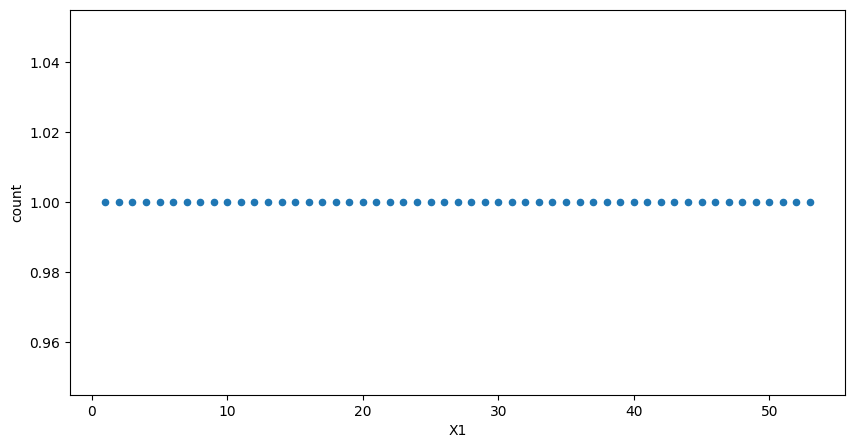

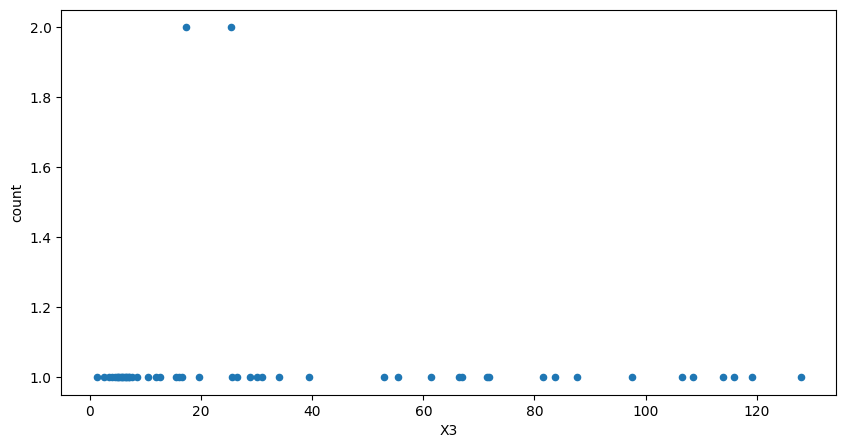

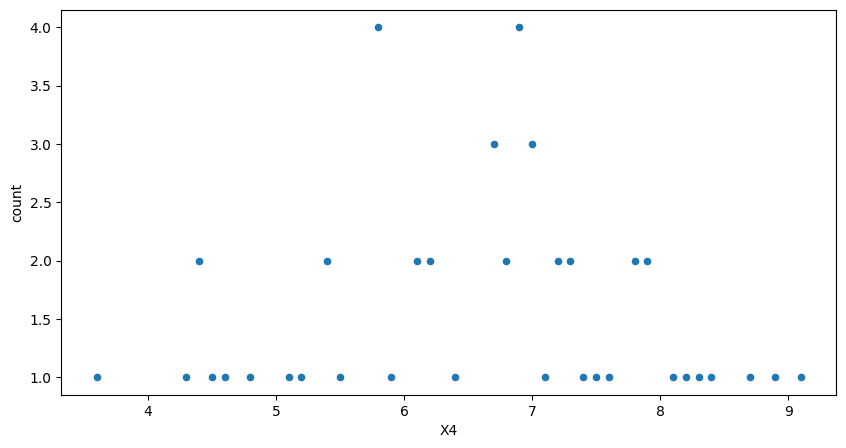

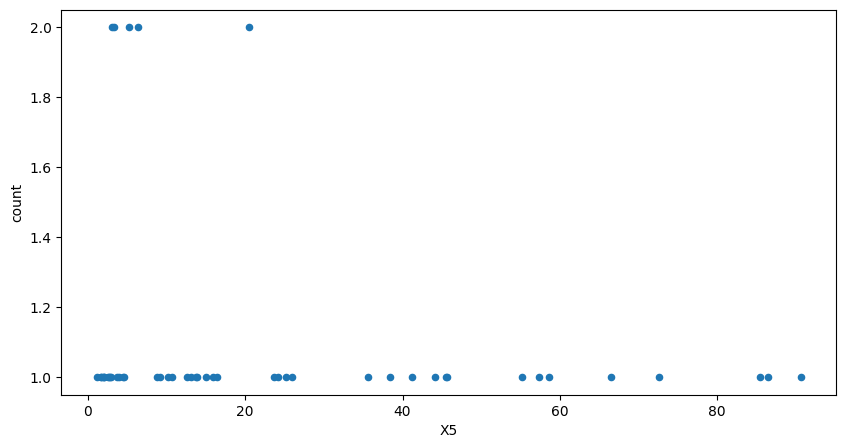

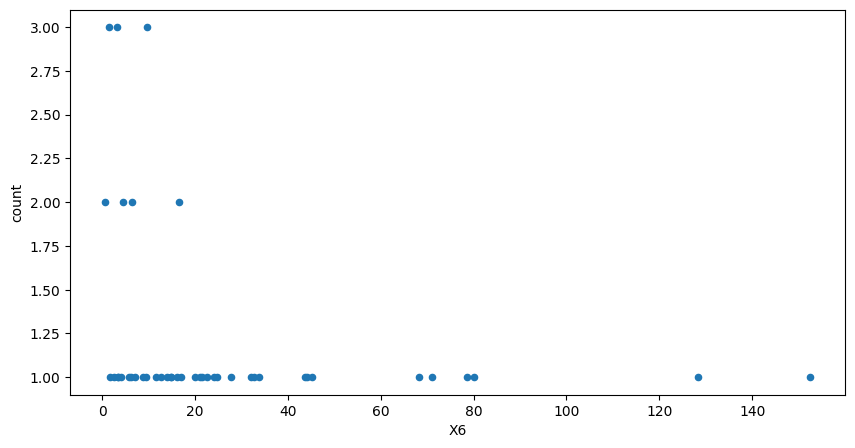

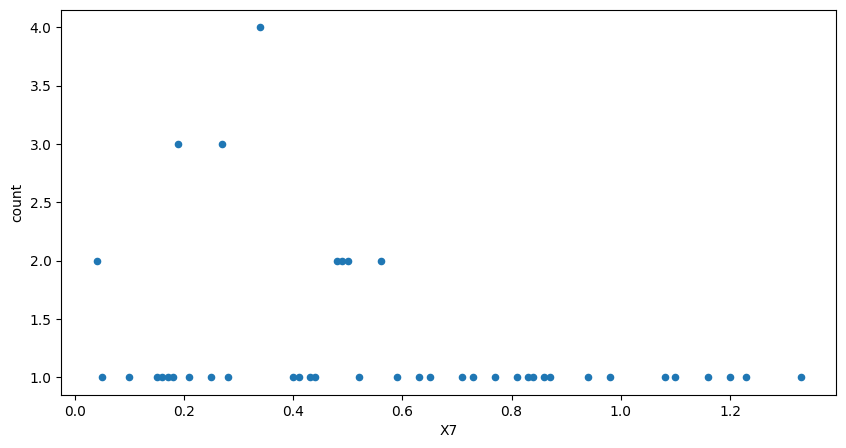

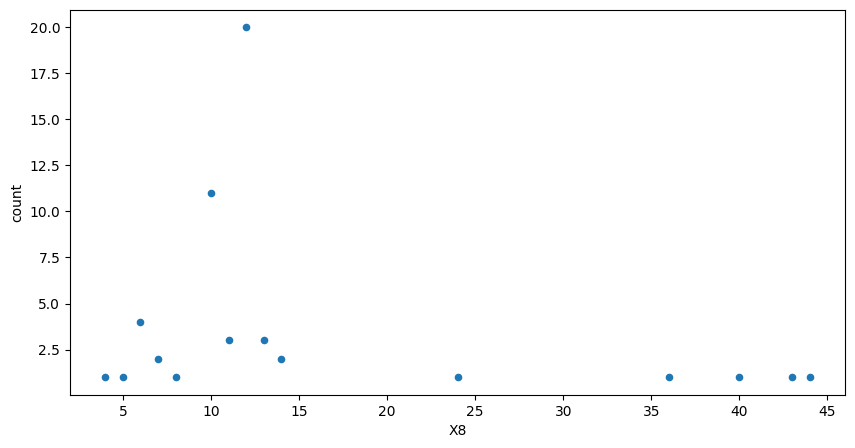

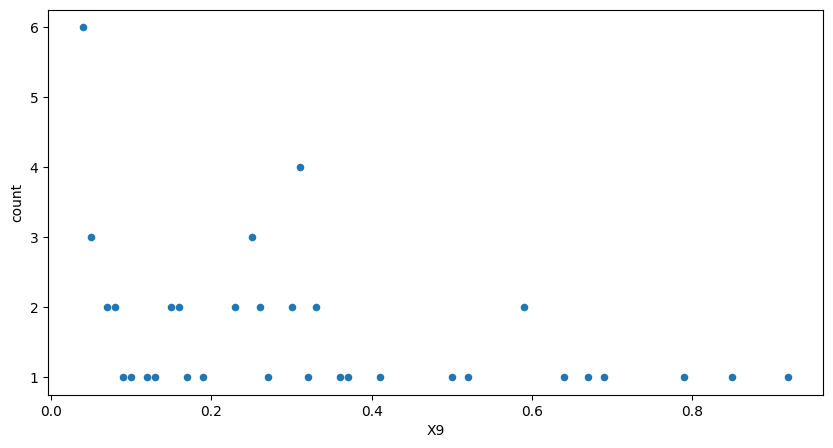

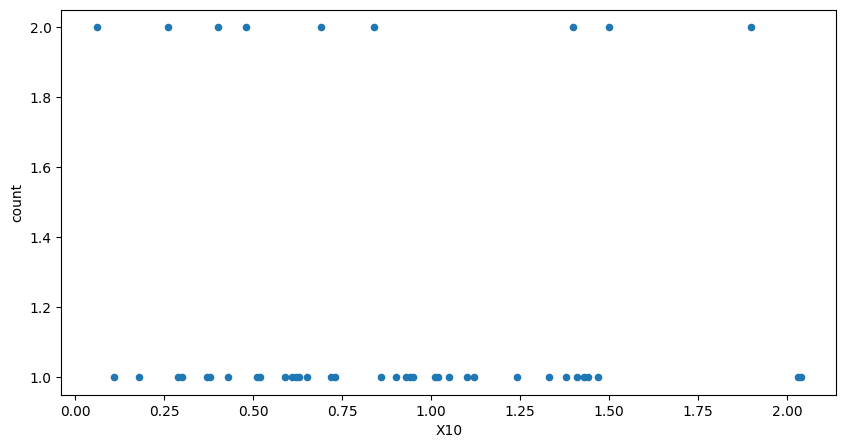

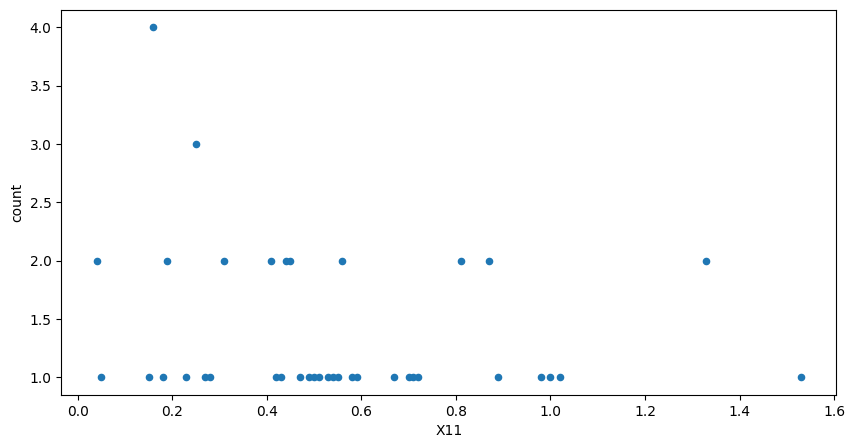

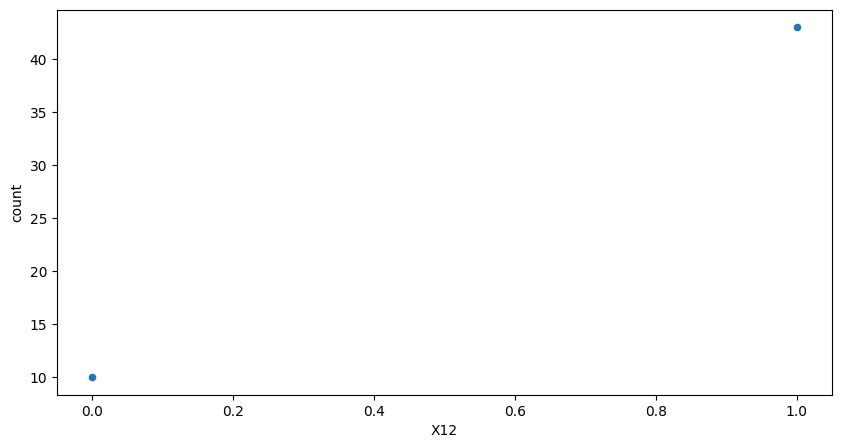

In [9]:
for col in df.select_dtypes(include ='number').columns:
    print(col)
    conteo = df.groupby(by=col).size().reset_index(name="count")
    moda = conteo.max().values
    print(f"moda: {moda[0]} por haber {moda[1]} datos")
    print(f"rango: {df[col].max()-df[col].min()}")
    unique_col = list(df[col].unique())
    print("Unique elements qty: " + str(len(unique_col)))
    print("Elements example:  " + str(unique_col[:10]) + "\n")
    conteo.plot.scatter(x = col, y="count", figsize=[10,5])

Todas las variables son cuantitativas y continuas
 
 También nos damos cuenta que X12 debería ser no númerica.

Cuartiles
0.0 	 1.0
0.25 	 14.0
0.5 	 27.0
0.75 	 40.0
1.0 	 53.0


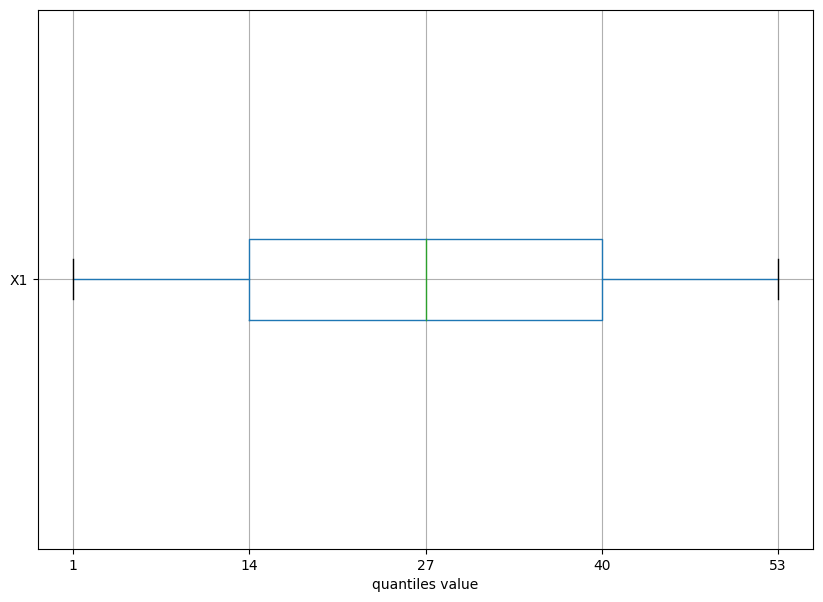

Cuartiles
0.0 	 1.2
0.25 	 6.6
0.5 	 19.6
0.75 	 66.5
1.0 	 128.0


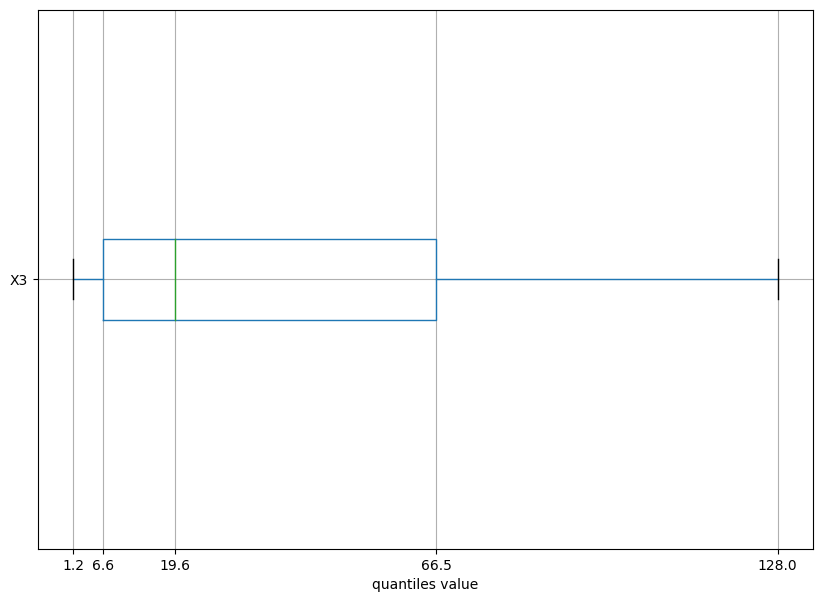

Cuartiles
0.0 	 3.6
0.25 	 5.8
0.5 	 6.8
0.75 	 7.4
1.0 	 9.1


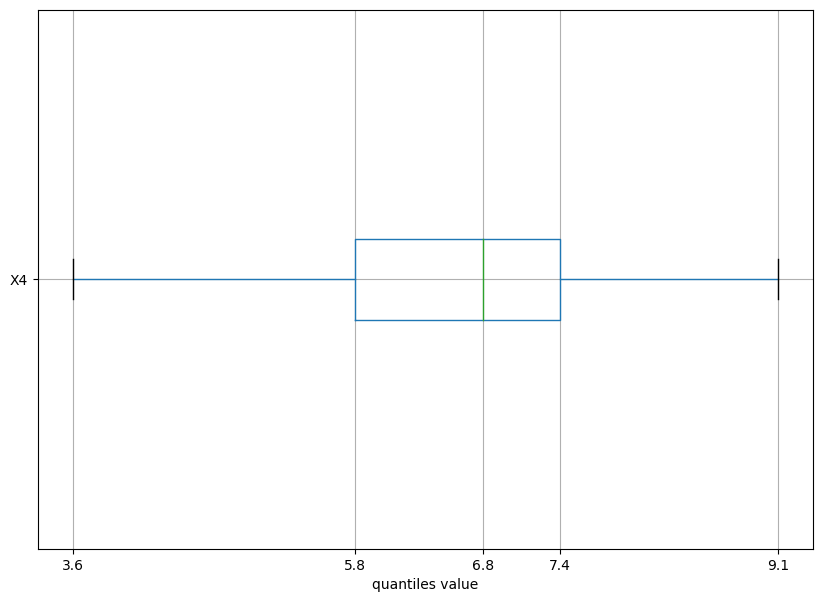

Cuartiles
0.0 	 1.1
0.25 	 3.3
0.5 	 12.6
0.75 	 35.6
1.0 	 90.7


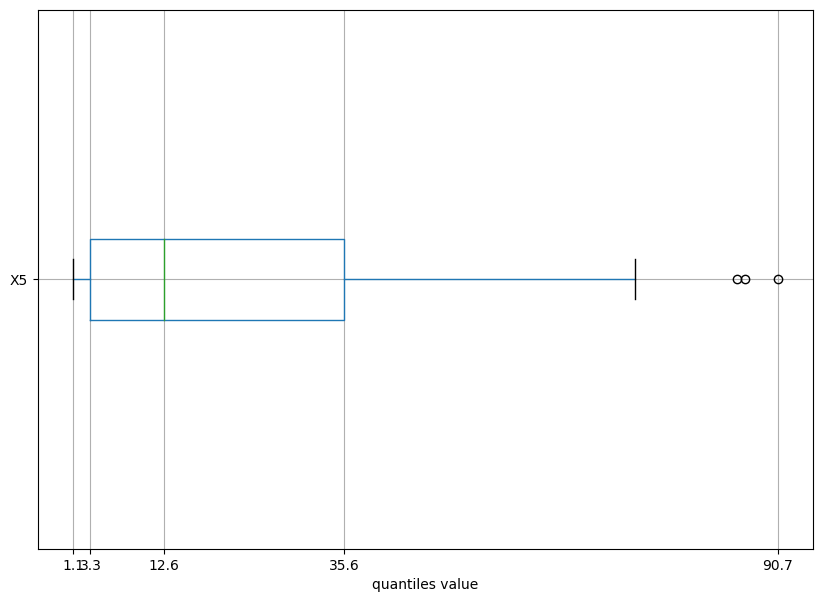

Cuartiles
0.0 	 0.7
0.25 	 4.6
0.5 	 12.8
0.75 	 24.7
1.0 	 152.4


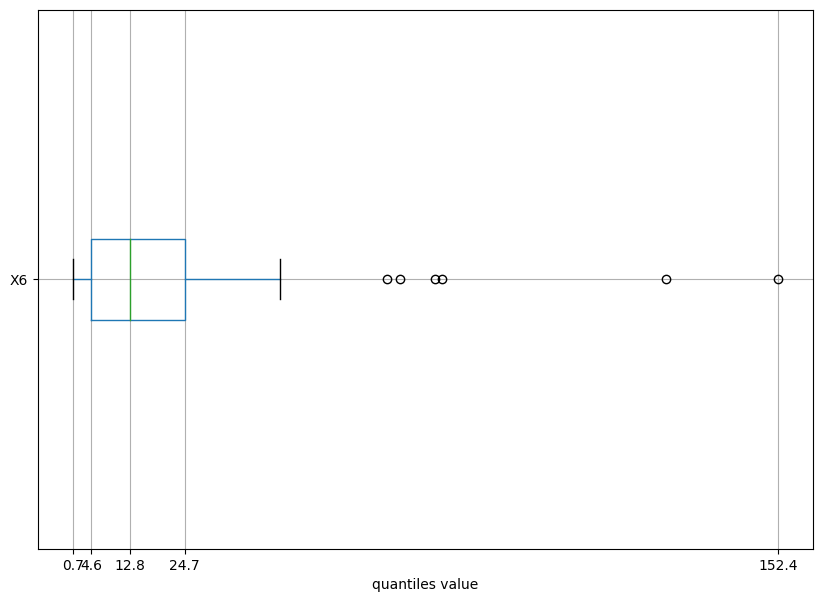

Cuartiles
0.0 	 0.04
0.25 	 0.27
0.5 	 0.48
0.75 	 0.77
1.0 	 1.33


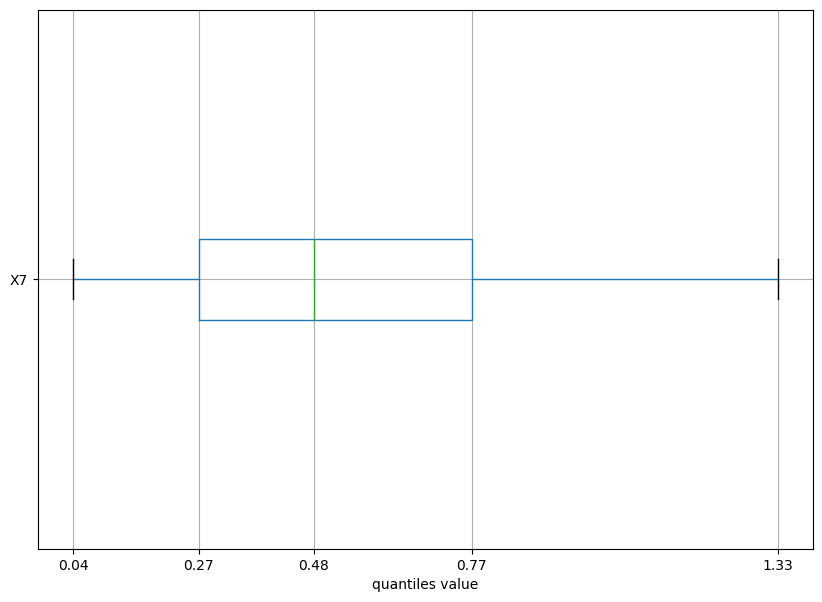

Cuartiles
0.0 	 4.0
0.25 	 10.0
0.5 	 12.0
0.75 	 12.0
1.0 	 44.0


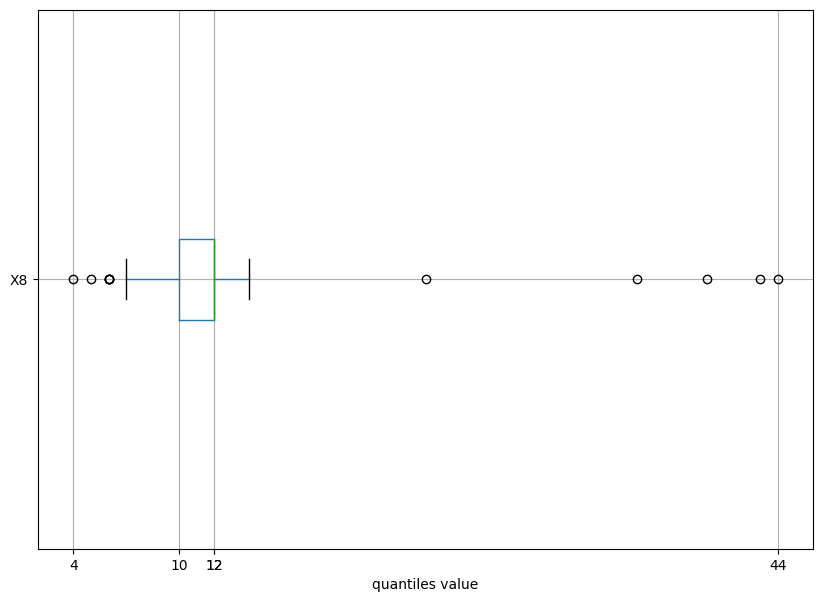

Cuartiles
0.0 	 0.04
0.25 	 0.09
0.5 	 0.25
0.75 	 0.33
1.0 	 0.92


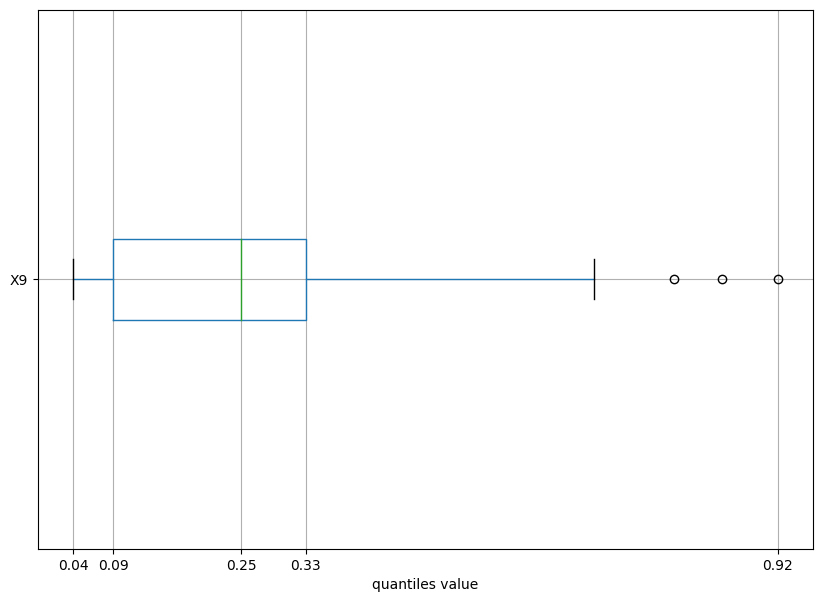

Cuartiles
0.0 	 0.06
0.25 	 0.48
0.5 	 0.84
0.75 	 1.33
1.0 	 2.04


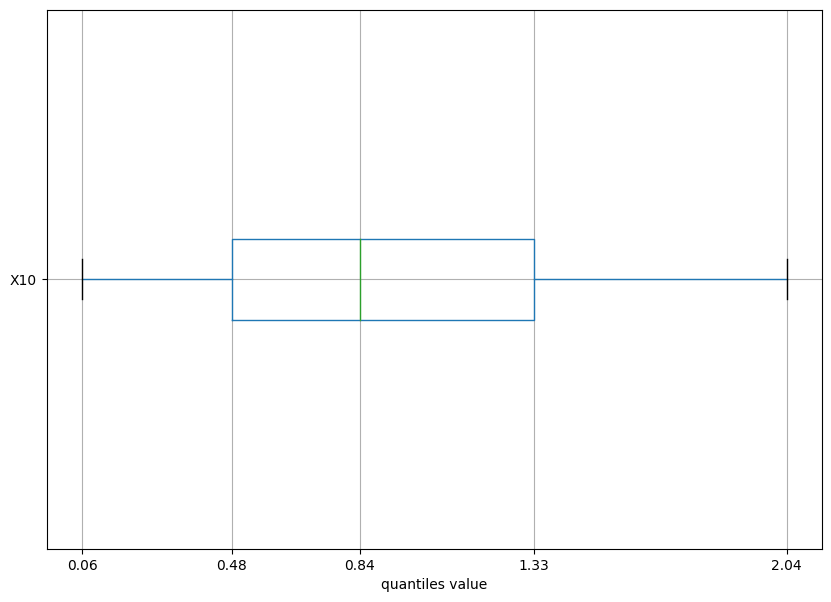

Cuartiles
0.0 	 0.04
0.25 	 0.25
0.5 	 0.45
0.75 	 0.7
1.0 	 1.53


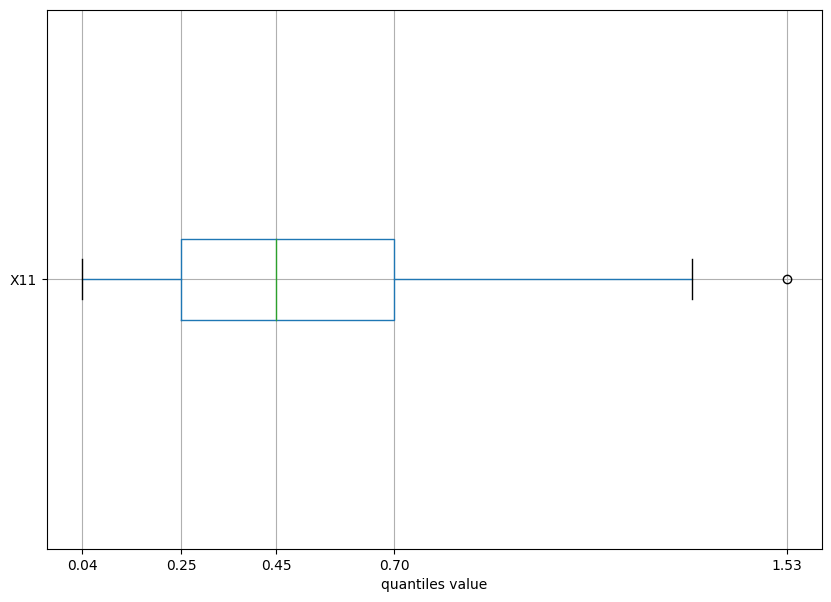

Cuartiles
0.0 	 0.0
0.25 	 1.0
0.5 	 1.0
0.75 	 1.0
1.0 	 1.0


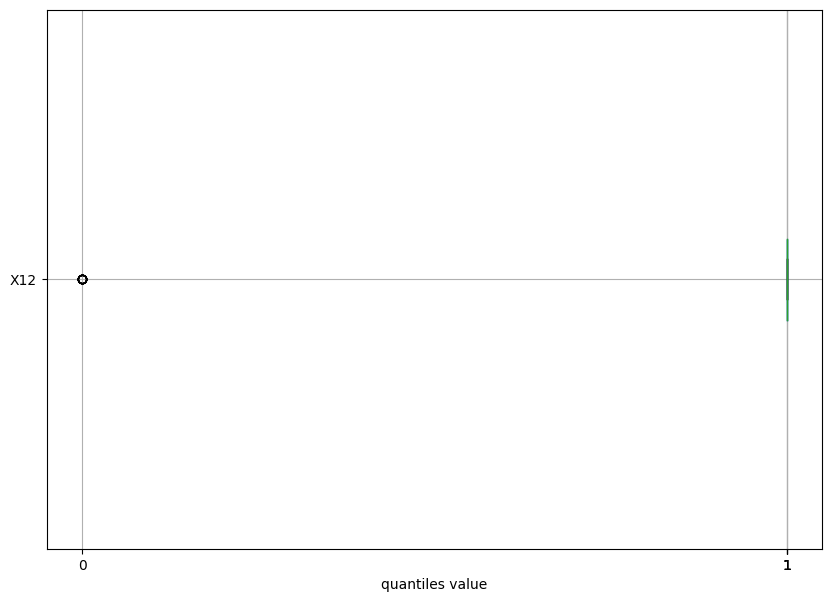

In [10]:
for col in df.select_dtypes(include ='number').columns:
    var = df[[col]]
    ax = var.boxplot(figsize=[10,7], vert=False)

    items = [0.00, 0.25, 0.50, 0.75, 1.00]
    quantiles = np.quantile(var, np.array(items))
    ax.vlines(quantiles, [0] * quantiles.size, [1] * quantiles.size,
            color='b', ls=':', lw=0.5, zorder=0)
    ax.set_ylim(0.5, 1.5)
    ax.set_xticks(quantiles)
    ax.set_xlabel('quantiles value')

    print("Cuartiles")
    for pair in zip(items, quantiles):
        print(pair[0], "\t", pair[1])

    plt.show()

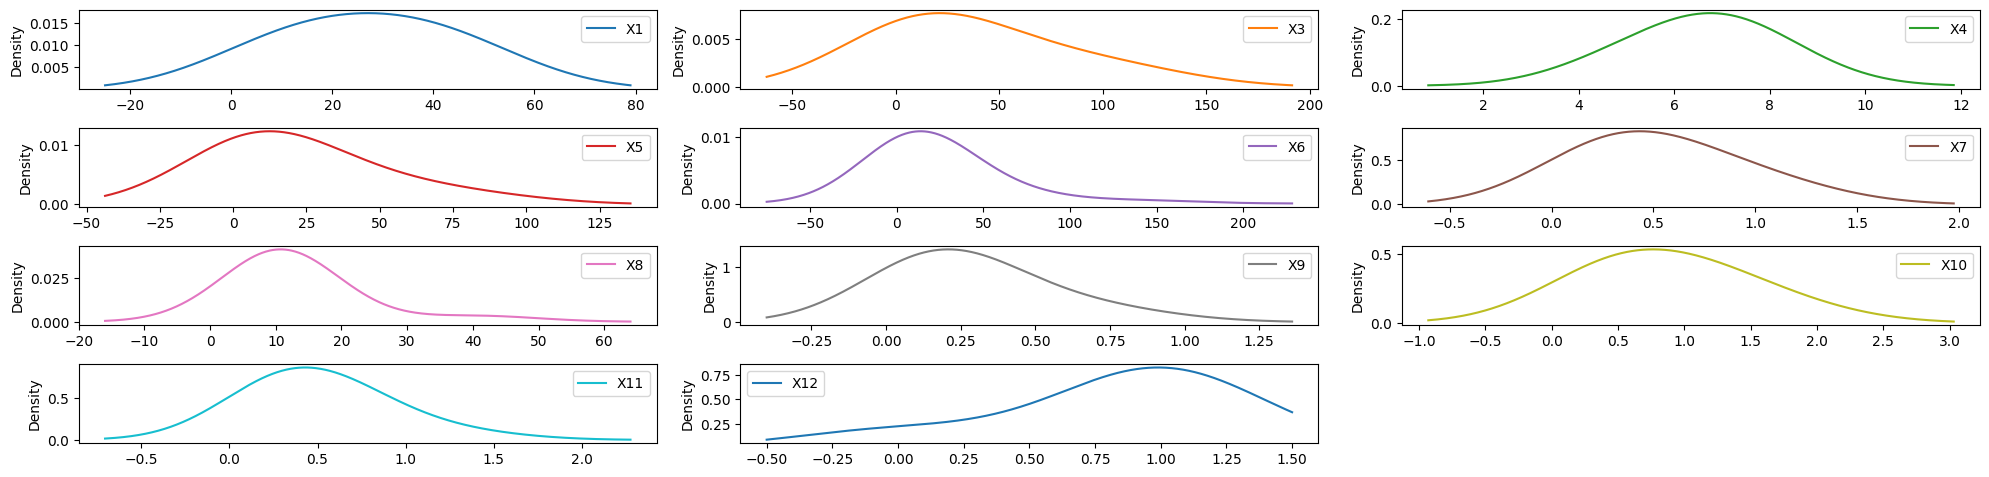

In [11]:
df.select_dtypes(include ='number').plot.kde(bw_method=1, subplots=True, layout=(6,3), sharex=False, figsize=[20,7])
plt.tight_layout()

**Asímetrico**
Ninguna


### NON NUMERIC - CUALITATIVE

In [12]:
# Corregir remote_ratio desde que es categórica
df["X12"] = df["X12"].astype('object')

In [13]:
display(df.select_dtypes(include ='object').describe(include = 'O').T)

,count,unique,top,freq
X2,53,53,Alligator,1
X12,53,2,1,43


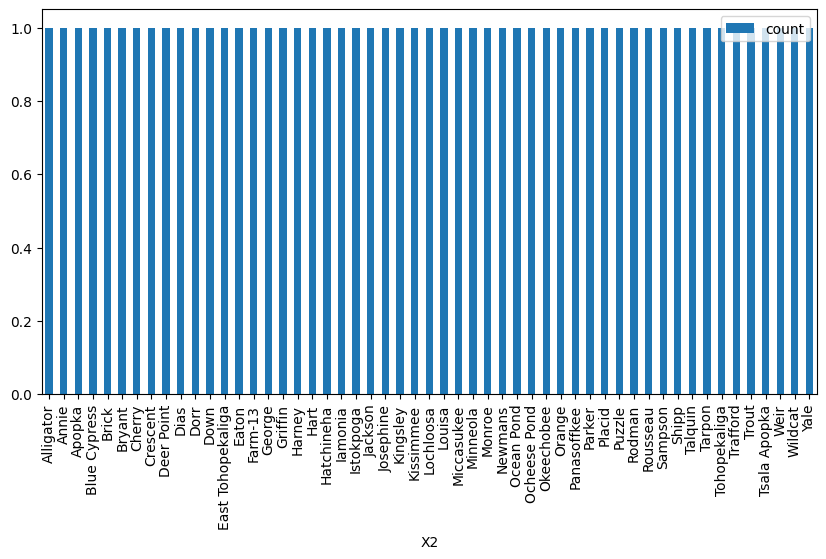

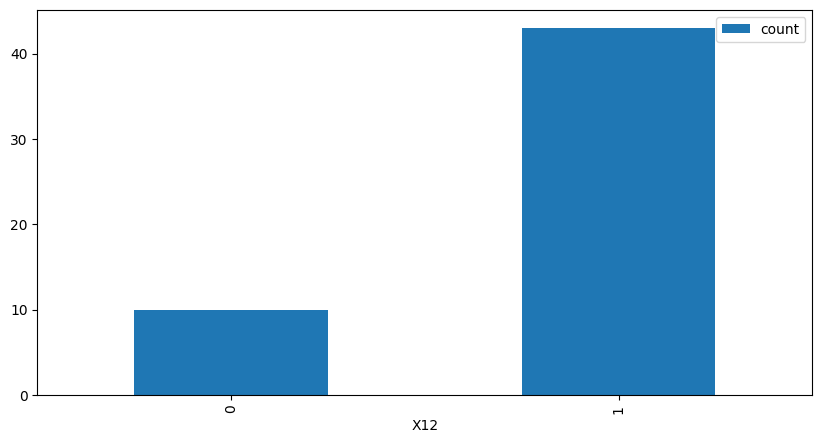

In [14]:
for col in df.select_dtypes(include ='object').columns:
    conteo = df.groupby(by=col).size().reset_index(name="count")
    conteo.plot.bar(x = col, y="count", figsize=[10,5])

* **X2** es multi nominal
* **X12** es dicotomico - ordinal

# Question Analysis

* ¿Cuál es el salario al que pueda aspirar un analista de datos?
* ¿En qué países se ofrecen mejores salarios?
* ¿Se han incrementado los salarios a lo largo del tiempo?
* ¿Influye el nivel de experiencia en el salario?
* ¿Influye el tamaño de la compañía en el salario que puede ofrecer a un analista de datos?
* ¿Qué tipo de contrato (parcial, tiempo completo, etc) ofrece mejores salarios? ¿Qué tipo de contrato será el más conveniente?
* Otras más que creas que se pueden contestar a partir de la base de datos.

## Preprocessing

In [15]:
# Outliers in numeric variables
print(len(df))
var = df[(np.abs(zscore(df.select_dtypes(include ='number'))) < 2).all(axis=1)] # 2, because otherwsie outliers would impact the normalization of data
print(len(var))

53
37


### Scaling & Normalization


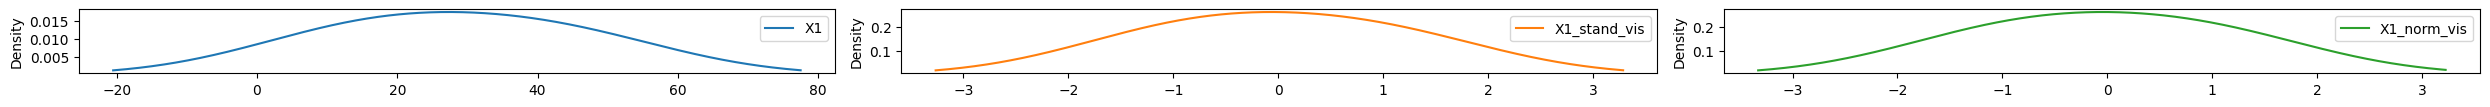

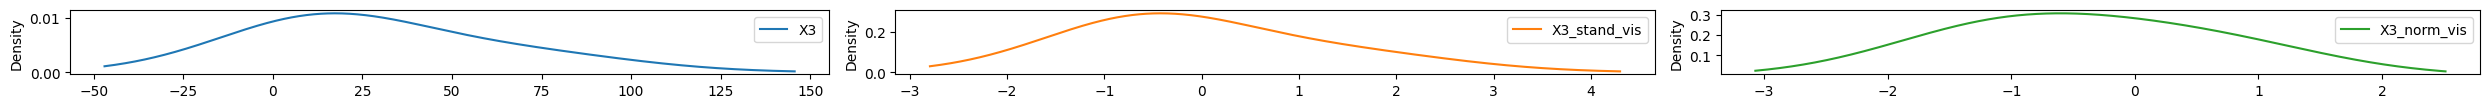

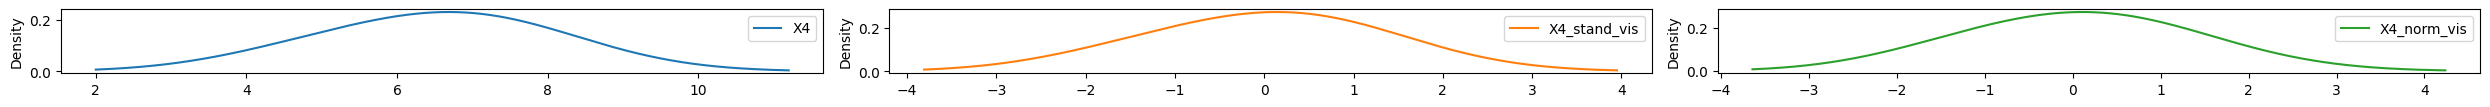

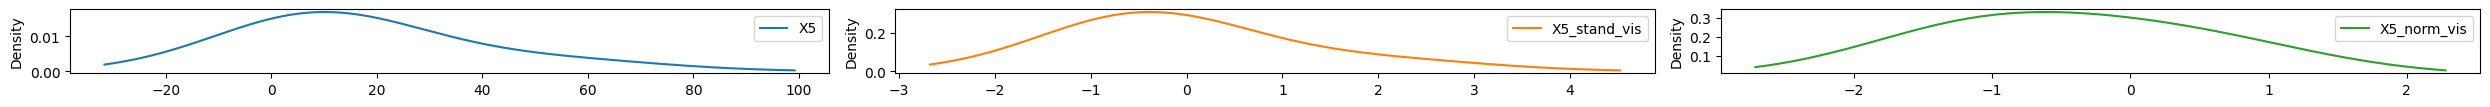

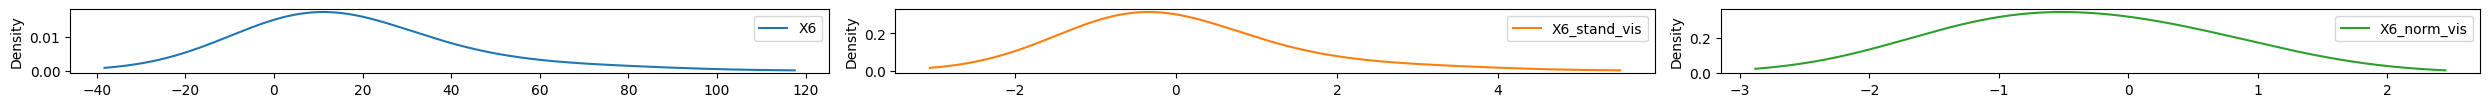

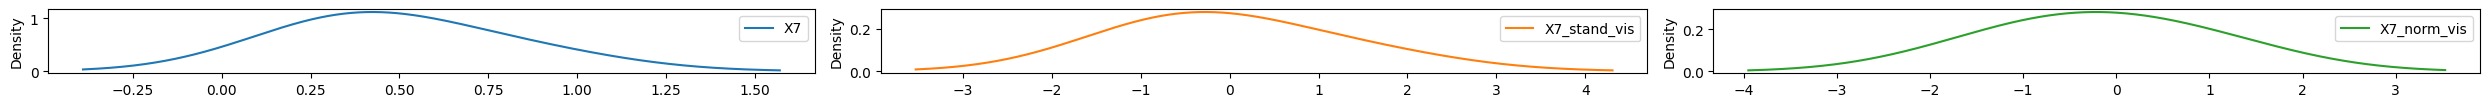

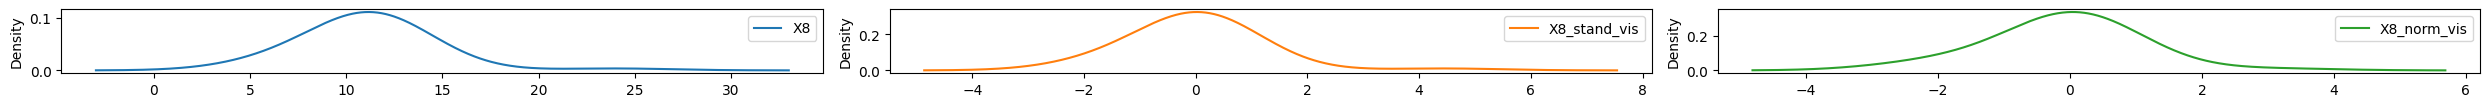

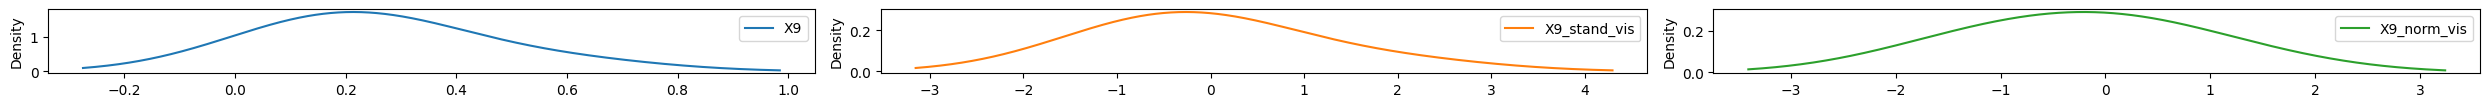

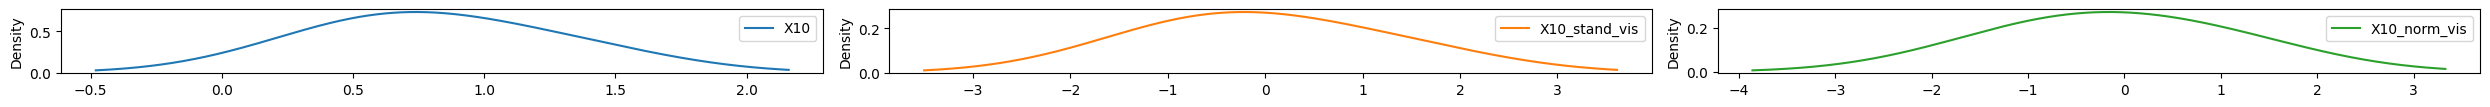

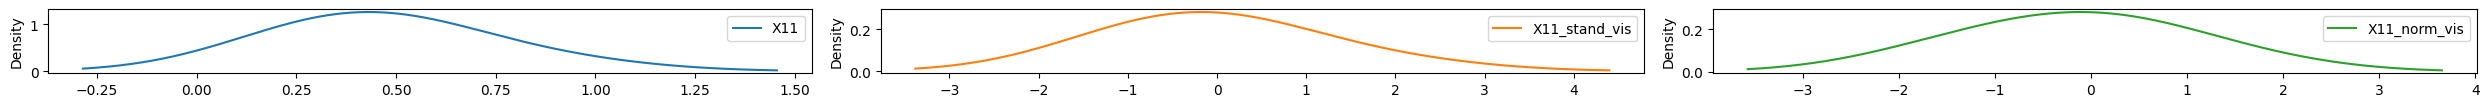

In [16]:
from sklearn.preprocessing import StandardScaler

for col in var.select_dtypes(include ='number').columns:
    # Scaling
    scaler = StandardScaler()
    var[f"{col}_stand_vis"] = scaler.fit_transform(var[[col]])

    # Normalization
    x_norm, _ = yeojohnson(var[f"{col}_stand_vis"])
    var[f"{col}_norm_vis"] = x_norm  
    
    # Eval Scale & Normalization
    var[[col, f"{col}_stand_vis", f"{col}_norm_vis" ]].plot.kde(bw_method=1, subplots=True, layout=(3,3), sharex=False, figsize=[25,3])
    plt.tight_layout()

In [17]:
# normalization of salary cause it wasn't normal
for col in var.select_dtypes(include ='number').columns:
    if "vis" not in col:
        var[col] = var[f"{col}_norm_vis"]
        var.drop(columns=[f"{col}_stand_vis", f"{col}_norm_vis"], inplace=True)     
var.head()

,X1,X2,X3,X4,X5,X6,X7,X8,X9,X10,X11,X12
3,-1.690072,Blue Cypress,0.316842,0.332581,-0.035806,-1.190140,-0.222585,0.292450,-0.922181,0.054185,-0.143924,0
5,-1.547668,Bryant,-0.413424,0.695468,-1.045918,0.762073,-1.066802,0.870423,-1.743032,-1.021909,-1.154399,1
6,-1.476658,Cherry,-1.348819,-0.881031,-1.246824,-1.202222,-0.052529,-0.406097,0.229480,-0.279013,-0.097213,1
7,-1.405780,Crescent,0.860619,1.460635,0.917624,0.568723,-1.524183,0.292450,-1.361815,-1.356383,-1.702431,1
8,-1.335038,Deer Point,-0.096793,-0.576946,-0.566638,-1.428764,1.065092,3.065233,0.009556,1.331898,0.945237,1


# FEATURE SELECTION

### Pearson

In [18]:
var.corr()["X7"].sort_values(ascending=False)

X7     1.000000
X10    0.945751
X11    0.945466
X9     0.875794
X8    -0.103722
X1    -0.214581
X6    -0.309844
X5    -0.359206
X4    -0.532256
X3    -0.597086
Name: X7, dtype: float64

De acuerdo con esto las más impactantes en un top 3 serían X11, X9, y x10

### P value of each numeic

In [19]:
calculate_pvalues(var)["X7"].sort_values(ascending=True)

X7        0.0
X9        0.0
X10       0.0
X11       0.0
X3     0.0001
X4     0.0007
X5      0.029
X6      0.062
X1     0.2022
X8     0.5413
Name: X7, dtype: object

Esto concuerda con que las más impactantes en un top 3 serían X11, X9, y x10

## One Way Test for each categorical

In [20]:
oneway_all_columns(df.drop(columns=["X1"]), "X7") 

/home/repos/mysql/school/lib/python3.8/site-packages/scipy/stats/_stats_py.py:3877: DegenerateDataWarning: all input arrays have length 1.  f_oneway requires that at least one input has length greater than 1.
  warnings.warn(stats.DegenerateDataWarning(msg))


,column,F,P-value,Statistically significant (pval < 05)
0,X2,NaN,NaN,False
1,X12,0.610248,0.438306,False


Desde aquí podemos ver que como tal los grupos y su impacto en X7 no es significativo

In [21]:
model = ols("X7 ~ C(X12)", data= var).fit()
anova_table(anova_lm(model, typ=2))

,sum_sq,df,mean_sq,F,PR(>F),eta_sq,omega_sq
C(X12),0.058972,1.0,0.058972,0.060205,0.807605,0.001717,-0.026062
Residual,34.283142,35.0,0.979518,NaN,NaN,NaN,NaN


Desde aquí podemos ver que tiene un málismo omegasq

In [22]:
S, p  = shapiro(model.resid)
print(S, p, "significant" if p<0.05 else "not that significant")

0.9762853384017944 0.6028062701225281 not that significant


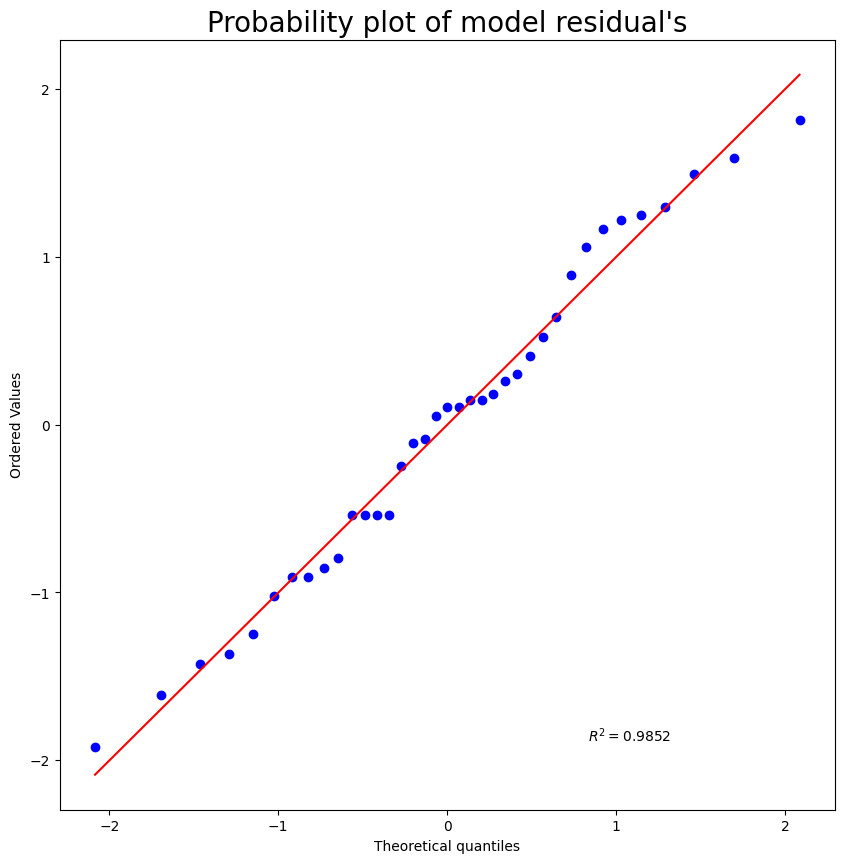

In [23]:
fig = plt.figure(figsize= (10, 10))
ax = fig.add_subplot(111)
normality_plot, stat = probplot(model.resid, plot= plt, rvalue= True)
ax.set_title("Probability plot of model residual's", fontsize= 20)
ax.set

plt.show()

In [24]:
L, p = levene(var[var["X12"]==0].X7,
                      var[var["X12"]==1].X7)
print(L, p, "significant" if p<0.05 else "not that significant")

3.7671050524260896 0.0603574979077378 not that significant


Pues el modelo de anova al menos es representativo veamos más afondo

In [25]:
import statsmodels.stats.multicomp as mc

comp = mc.MultiComparison(var['X7'], var['X12'])
post_hoc_res = comp.tukeyhsd()
post_hoc_res.summary()

group1,group2,meandiff,p-adj,lower,upper,reject
0,1,0.1168,0.8076,-0.8494,1.083,False


/tmp/ipykernel_3813/534653529.py:1: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  post_hoc_res.plot_simultaneous(ylabel= "Country", xlabel= "Score Difference", ).show()


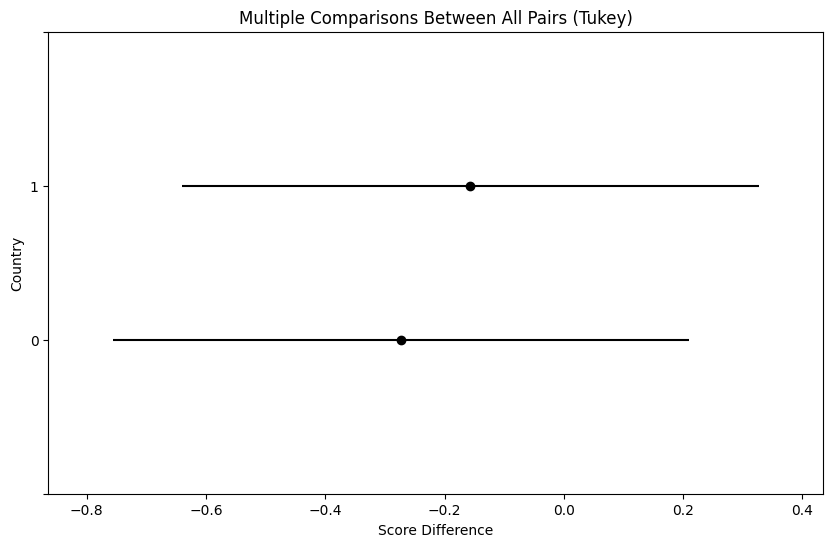

In [26]:
post_hoc_res.plot_simultaneous(ylabel= "Country", xlabel= "Score Difference", ).show()

También la diferencia entre los grupos no se ve como mucha

# MANOVA

In [27]:
from statsmodels.multivariate.manova import MANOVA

formula = 'X3 + X4 + X5 + X6 + X8 + X9 + X10 + X11 + X7 ~ C(X12)  ' # formula                                        
maov = MANOVA.from_formula(formula, data=var)
print(maov.mv_test())

                 Multivariate linear model
                                                            
------------------------------------------------------------
       Intercept        Value  Num DF  Den DF F Value Pr > F
------------------------------------------------------------
          Wilks' lambda 0.6312 9.0000 27.0000  1.7527 0.1251
         Pillai's trace 0.3688 9.0000 27.0000  1.7527 0.1251
 Hotelling-Lawley trace 0.5842 9.0000 27.0000  1.7527 0.1251
    Roy's greatest root 0.5842 9.0000 27.0000  1.7527 0.1251
------------------------------------------------------------
                                                            
------------------------------------------------------------
         C(X12)         Value  Num DF  Den DF F Value Pr > F
------------------------------------------------------------
          Wilks' lambda 0.8216 9.0000 27.0000  0.6515 0.7437
         Pillai's trace 0.1784 9.0000 27.0000  0.6515 0.7437
 Hotelling-Lawley trace 0.2172 9.0000 27.0

Aqu{i el objetivo es ver cómo los grupos de X12 (Jóvenes y maduroz) impactan en las otras variables ya en conjunto estas y podemos ver que en realidad so impacto ni siquiera es significativo

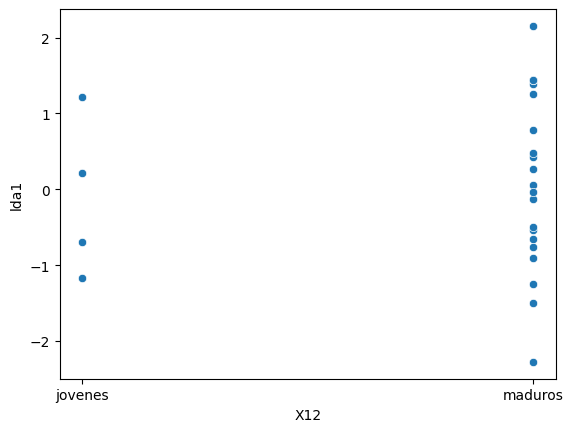

In [28]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as lda

var["X12"] = var["X12"].astype("int32")
X = var[["X3", "X4", "X5", "X6", "X7", "X8", "X9", "X10", "X11"]]
y = var["X12"]

# X_new = pd.DataFrame(lda().fit(X=X, y=y).transform(X), columns=["lda1", "lda2"])
X_new = pd.DataFrame(lda(n_components=1).fit_transform(X=X, y=y), columns=["lda1"]) #, "lda2"]) no lda as there's only 2 groups
X_new["X12"] = var["X12"]
X_new["X12"] = X_new["X12"].replace({0: "jovenes", 1:"maduros"})
sns.scatterplot(data=X_new, x="X12", y="lda1")
#sns.scatterplot(data=X_new, x="lda1", y="lda2", hue=df.plant_var.tolist())
plt.show()

No hay mucha similitud entre los grupso

# FEATURE SELECTION

In [29]:
print("forward_regression", forward_regression(var.drop(columns=["X1","X2", "X7"]), var["X7"], 0.01, True))
print("backward_regression", backward_regression(var.drop(columns=["X1", "X2", "X7"]), var["X7"], 0.05, True))
print("stepwise", stepwise_selection(var.drop(columns=["X1", "X2", "X7"]), var["X7"], verbose = True))

Add  X10                            with p-value 1.1496e-18
Add  X11                            with p-value 9.59721e-08
forward_regression ['X10', 'X11']
Drop X6                             with p-value 0.623
Drop X12                            with p-value 0.560776
Drop X3                             with p-value 0.346677
Drop X8                             with p-value 0.34558
Drop X5                             with p-value 0.0731679
Drop X4                             with p-value 0.253343
backward_regression ['X9', 'X10', 'X11']
Add  X10                            with p-value 1.1496e-18
Add  X11                            with p-value 9.59721e-08
stepwise ['X10', 'X11']


# FIRST MODEL 
- Todas las variables

In [30]:
for col in var.select_dtypes(include="object"):
    var[col] = var[col].astype('category')
    var[col] = var[col].cat.codes  
var.head()

,X1,X2,X3,X4,X5,X6,X7,X8,X9,X10,X11,X12
3,-1.690072,0,0.316842,0.332581,-0.035806,-1.190140,-0.222585,0.292450,-0.922181,0.054185,-0.143924,0
5,-1.547668,1,-0.413424,0.695468,-1.045918,0.762073,-1.066802,0.870423,-1.743032,-1.021909,-1.154399,1
6,-1.476658,2,-1.348819,-0.881031,-1.246824,-1.202222,-0.052529,-0.406097,0.229480,-0.279013,-0.097213,1
7,-1.405780,3,0.860619,1.460635,0.917624,0.568723,-1.524183,0.292450,-1.361815,-1.356383,-1.702431,1
8,-1.335038,4,-0.096793,-0.576946,-0.566638,-1.428764,1.065092,3.065233,0.009556,1.331898,0.945237,1


In [31]:
from statsmodels.formula.api import ols
from statsmodels.stats.anova import anova_lm

formula = 'X7 ~ X3 + X4 + X5 + X6 + X8 + X9 + X10 + X11 + C(X12)' # formula                                        
model = ols(formula, var).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                     X7   R-squared:                       0.969
Model:                            OLS   Adj. R-squared:                  0.958
Method:                 Least Squares   F-statistic:                     92.37
Date:                Tue, 13 Sep 2022   Prob (F-statistic):           6.25e-18
Time:                        23:00:59   Log-Likelihood:                 12.873
No. Observations:                  37   AIC:                            -5.747
Df Residuals:                      27   BIC:                             10.36
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept       0.0145      0.113      0.129      

De acuerdo a lo observado aquí lo más  relevante (por la P>|t| ) los factores serían como ya habíamos visto por el backward  x9, x10, x11, y  se entiende que el stepwise descartara X9 al estar muy cerca de .05

In [32]:
anova_table(anova_lm(model, typ=2)).sort_values(by="omega_sq", ascending=False)

,sum_sq,df,mean_sq,F,PR(>F),eta_sq,omega_sq
X10,1.702793,1.0,1.702793,42.560363,5.387424e-07,0.484351,0.467649
X11,0.292871,1.0,0.292871,7.320157,1.166710e-02,0.083306,0.071116
X9,0.187307,1.0,0.187307,4.681635,3.950134e-02,0.053279,0.041427
X5,0.126041,1.0,0.126041,3.150316,8.718869e-02,0.035852,0.024196
X4,0.041447,1.0,0.041447,1.035933,3.178034e-01,0.011789,0.000404
X3,0.034698,1.0,0.034698,0.867260,3.599678e-01,0.009870,-0.001494
X8,0.029053,1.0,0.029053,0.726162,4.016259e-01,0.008264,-0.003081
C(X12),0.011274,1.0,0.011274,0.281799,5.998642e-01,0.003207,-0.008081
X6,0.009895,1.0,0.009895,0.247312,6.229998e-01,0.002814,-0.008469
Residual,1.080240,27.0,0.040009,NaN,NaN,NaN,NaN


Con esto podemos ir viendo que definitivamente X12 iba a ser descartada

Pero, ¿Qué tan buen modelo es?

Assumption 1: Linear Relationship between the Target and the Feature 

Checking with a scatter plot of actual vs. predicted. Predictions should follow the diagonal line.


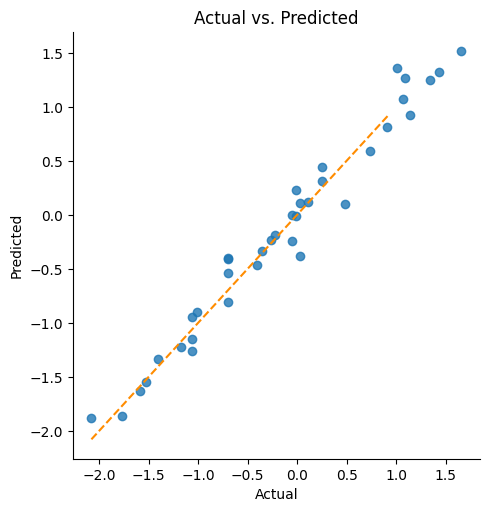

Assumption 2: The error terms are normally distributed 

Using the Anderson-Darling test for normal distribution
p-value from the test - below 0.05 generally means non-normal: 0.9689852460934048
Residuals are normally distributed


/tmp/ipykernel_3813/2158940722.py:221: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df_results['Residuals'])


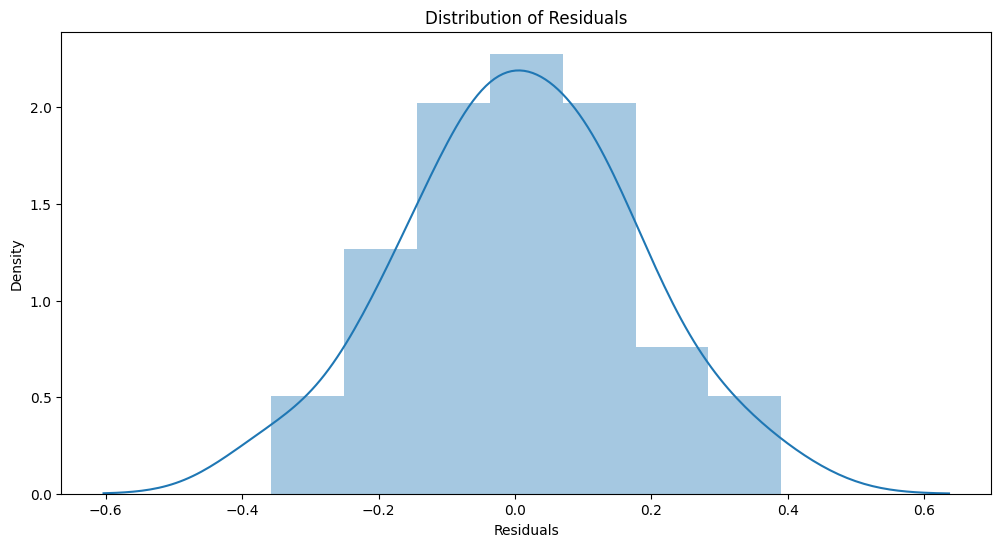


Assumption satisfied
Assumption 3: Little to no multicollinearity among predictors


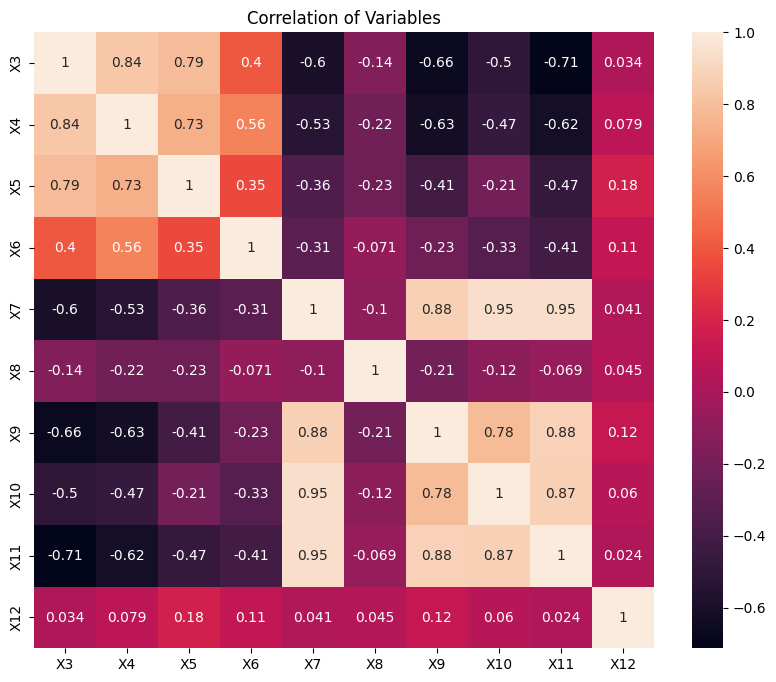

Variance Inflation Factors (VIF)
> 10: An indication that multicollinearity may be present
> 100: Certain multicollinearity among the variables
-------------------------------------
X3: 7.466224549499779
X4: 7.171254137591954
X5: 4.776071559225572
X6: 2.675781452970759
X7: 32.7892803691325
X8: 1.584983727703299
X9: 11.563524027902707
X10: 14.805292366456069
X11: 18.223955103953365
X12: 2.872613252045469

4 cases of possible multicollinearity
0 cases of definite multicollinearity

Assumption possibly satisfied

Coefficient interpretability may be problematic
Consider removing variables with a high Variance Inflation Factor (VIF)
Assumption 4: No Autocorrelation 


Performing Durbin-Watson Test
Values of 1.5 < d < 2.5 generally show that there is no autocorrelation in the data
0 to 2< is positive autocorrelation
>2 to 4 is negative autocorrelation
-------------------------------------
Durbin-Watson: 1.898818802438827
Little to no autocorrelation 

Assumption satisfied
Assumption 5: Homos

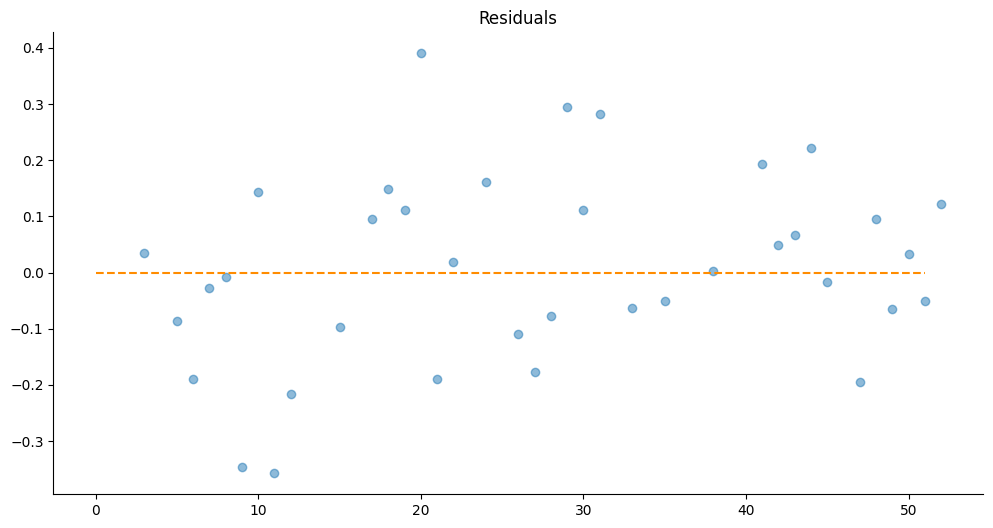

In [33]:
linear_assumption(model, var[["X3", "X4", "X5", "X6", "X7", "X8", "X9", "X10", "X11", "X12"]], var["X7"])
normal_errors_assumption(model, var[["X3", "X4", "X5", "X6", "X7", "X8", "X9", "X10", "X11", "X12"]], var["X7"])
multicollinearity_assumption(model, var[["X3", "X4", "X5", "X6", "X7", "X8", "X9", "X10", "X11", "X12"]], var["X7"], ["X3", "X4", "X5", "X6", "X7", "X8", "X9", "X10", "X11", "X12"])
autocorrelation_assumption(model, var[["X3", "X4", "X5", "X6", "X7", "X8", "X9", "X10", "X11", "X12"]], var["X7"])
homoscedasticity_assumption(model, var[["X3", "X4", "X5", "X6", "X7", "X8", "X9", "X10", "X11", "X12"]], var["X7"])

Dentro de lo que cabe es un modelo que tiene todas las assumptions

# MODEL BACKWARD


In [34]:
from sklearn.linear_model import LinearRegression

ml = LinearRegression()
ml.fit(var[['X11', 'X10', 'X9']], var["X7"])

ml_r2 = ml.score(var[['X11', 'X10', 'X9']], var["X7"])
print('R^2: {0}'.format(ml_r2))

formula = 'X7 ~ X9 + X10 + X11'
model = ols(formula, var).fit()
print(model.summary())
print(anova_lm(model))

R^2: 0.9604387299241609
                            OLS Regression Results                            
Dep. Variable:                     X7   R-squared:                       0.960
Model:                            OLS   Adj. R-squared:                  0.957
Method:                 Least Squares   F-statistic:                     267.0
Date:                Tue, 13 Sep 2022   Prob (F-statistic):           3.29e-23
Time:                        23:01:00   Log-Likelihood:                 8.6316
No. Observations:                  37   AIC:                            -9.263
Df Residuals:                      33   BIC:                            -2.820
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.0367      0

ASSUMPTIONS

Assumption 1: Linear Relationship between the Target and the Feature 

Checking with a scatter plot of actual vs. predicted. Predictions should follow the diagonal line.


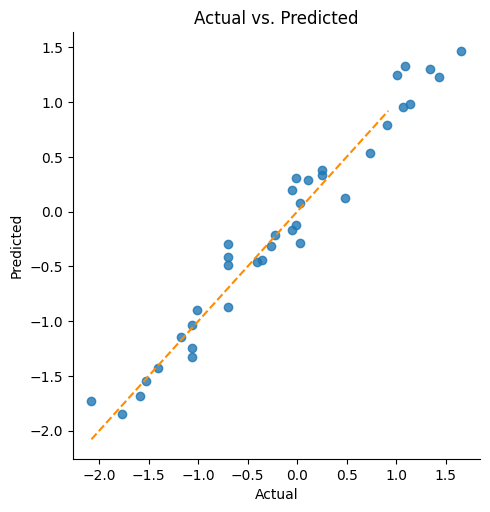

Assumption 2: The error terms are normally distributed 

Using the Anderson-Darling test for normal distribution
p-value from the test - below 0.05 generally means non-normal: 0.20140891059196558
Residuals are normally distributed


/tmp/ipykernel_3813/2158940722.py:221: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df_results['Residuals'])


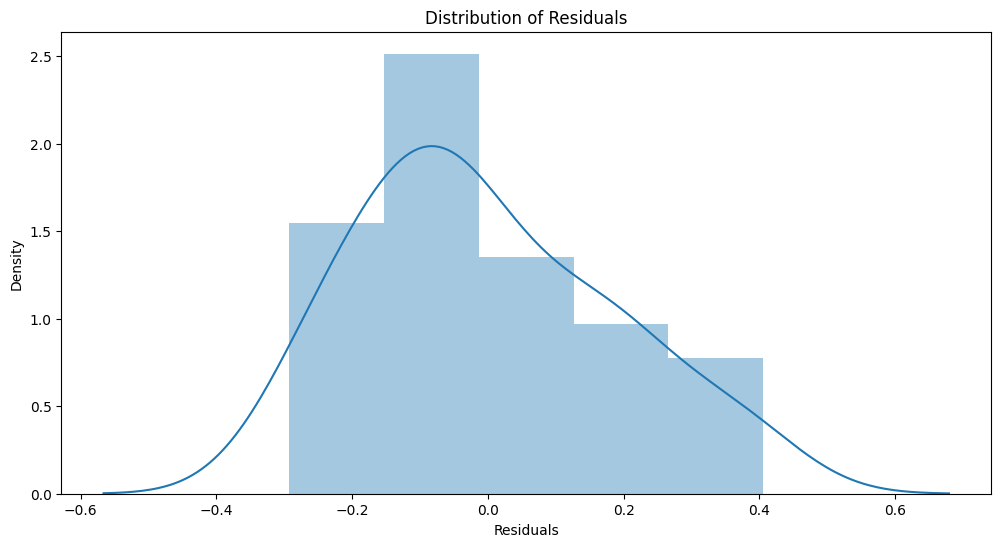


Assumption satisfied
Assumption 3: Little to no multicollinearity among predictors


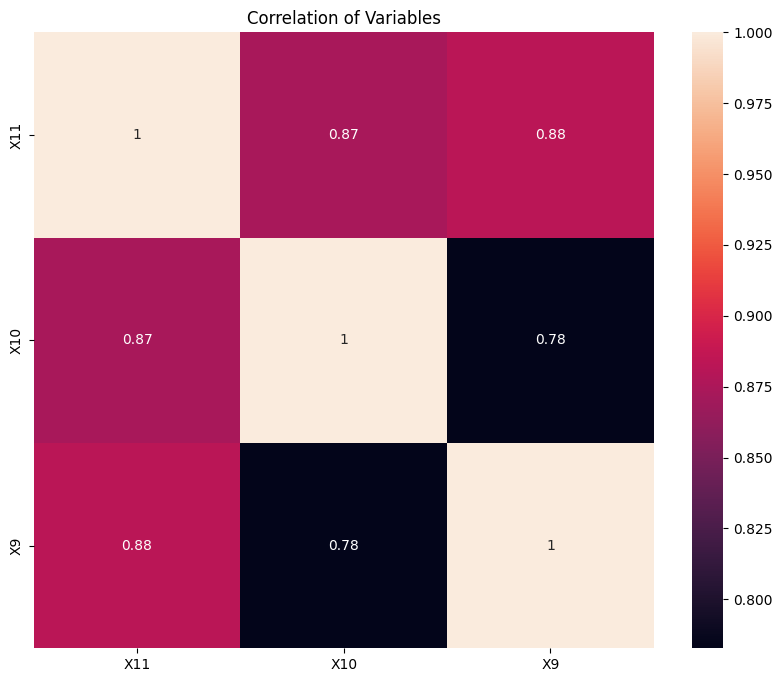

Variance Inflation Factors (VIF)
> 10: An indication that multicollinearity may be present
> 100: Certain multicollinearity among the variables
-------------------------------------
X11: 7.488195564844126
X10: 4.2602789225206115
X9: 4.558964761804626

0 cases of possible multicollinearity
0 cases of definite multicollinearity

Assumption satisfied
Assumption 4: No Autocorrelation 


Performing Durbin-Watson Test
Values of 1.5 < d < 2.5 generally show that there is no autocorrelation in the data
0 to 2< is positive autocorrelation
>2 to 4 is negative autocorrelation
-------------------------------------
Durbin-Watson: 1.941797669613185
Little to no autocorrelation 

Assumption satisfied
Assumption 5: Homoscedasticity of Error Terms 

Residuals should have relative constant variance


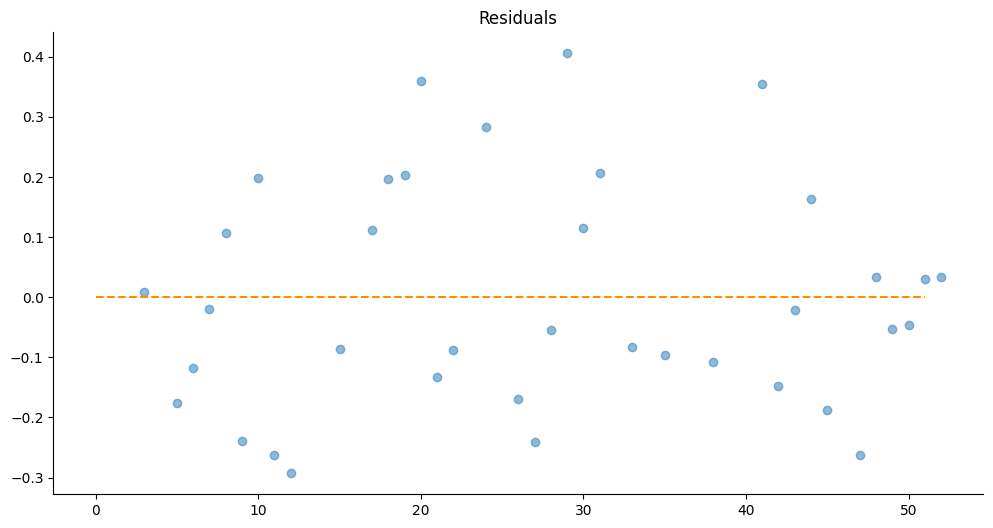

In [35]:
linear_assumption(ml, var[['X11', 'X10', 'X9']], var["X7"])
normal_errors_assumption(ml, var[['X11', 'X10', 'X9']], var["X7"])
multicollinearity_assumption(ml, var[['X11', 'X10', 'X9']], var["X7"], ['X11', 'X10', 'X9'])
autocorrelation_assumption(ml, var[['X11', 'X10', 'X9']], var["X7"])
homoscedasticity_assumption(ml, var[['X11', 'X10', 'X9']], var["X7"])

Este modelo también así como el que trae todas las variables cumple con las assumptions

# MODEL STEPWISE

In [36]:
from sklearn.linear_model import LinearRegression

ml = LinearRegression()
ml.fit(var[['X11', 'X10']], var["X7"])

ml_r2 = ml.score(var[['X11', 'X10']], var["X7"])
print('R^2: {0}'.format(ml_r2))

formula = 'X7 ~ X10 + X11'
model = ols(formula, var).fit()
print(model.summary())
print(anova_lm(model))

R^2: 0.954810885745995
                            OLS Regression Results                            
Dep. Variable:                     X7   R-squared:                       0.955
Model:                            OLS   Adj. R-squared:                  0.952
Method:                 Least Squares   F-statistic:                     359.2
Date:                Tue, 13 Sep 2022   Prob (F-statistic):           1.37e-23
Time:                        23:01:01   Log-Likelihood:                 6.1710
No. Observations:                  37   AIC:                            -6.342
Df Residuals:                      34   BIC:                            -1.509
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.0514      0.

Assumption 1: Linear Relationship between the Target and the Feature 

Checking with a scatter plot of actual vs. predicted. Predictions should follow the diagonal line.


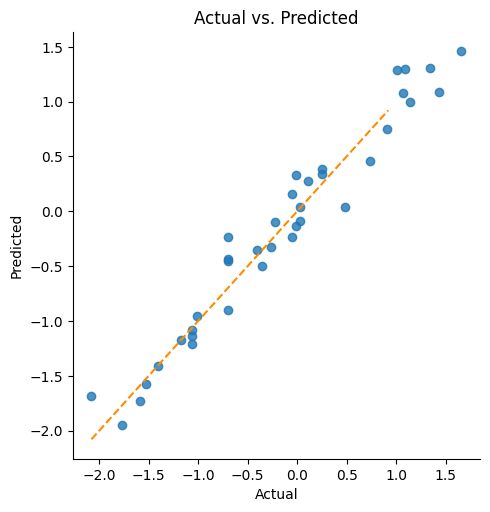

Assumption 2: The error terms are normally distributed 

Using the Anderson-Darling test for normal distribution
p-value from the test - below 0.05 generally means non-normal: 0.0314747693917015
Residuals are not normally distributed


/tmp/ipykernel_3813/2158940722.py:221: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df_results['Residuals'])


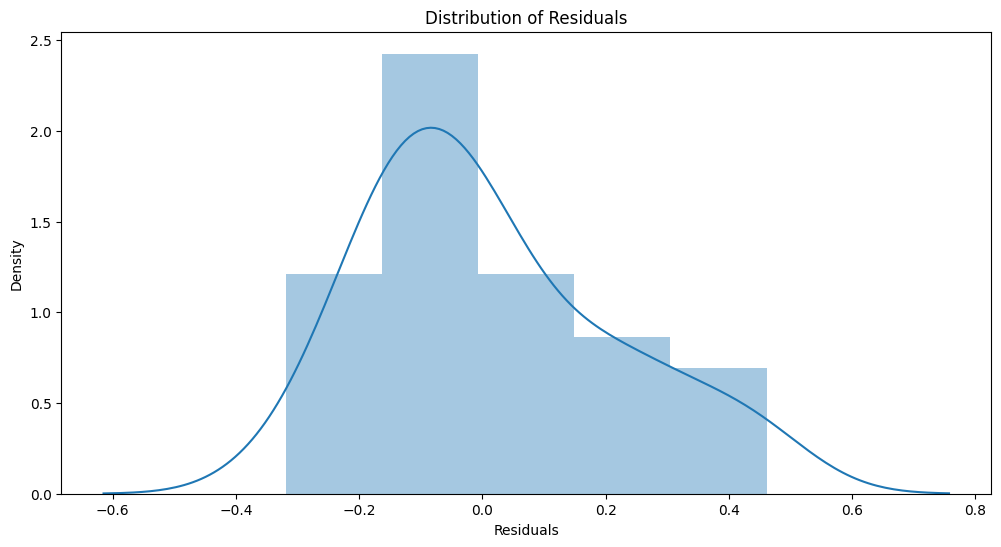


Assumption not satisfied

Confidence intervals will likely be affected
Try performing nonlinear transformations on variables
Assumption 3: Little to no multicollinearity among predictors


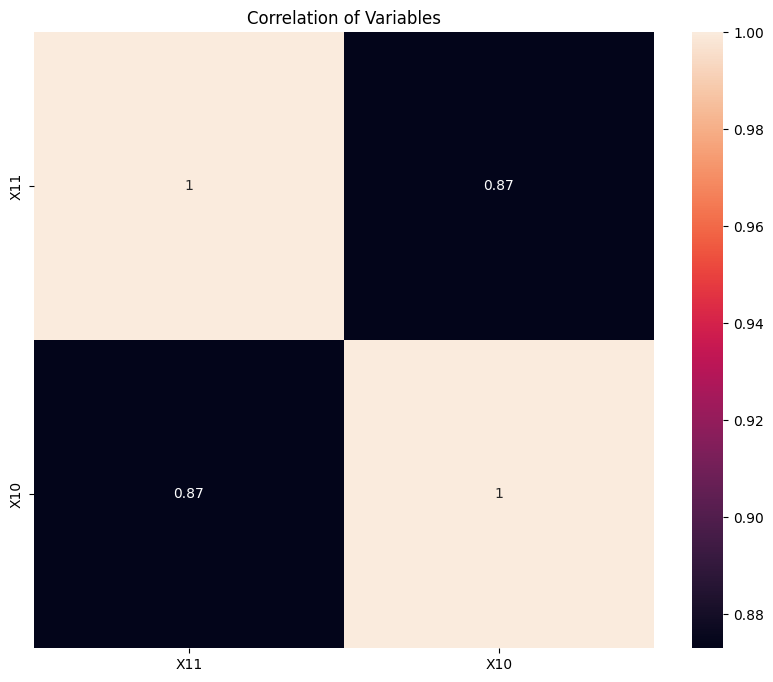

Variance Inflation Factors (VIF)
> 10: An indication that multicollinearity may be present
> 100: Certain multicollinearity among the variables
-------------------------------------
X11: 4.250484180998918
X10: 4.25048418099892

0 cases of possible multicollinearity
0 cases of definite multicollinearity

Assumption satisfied
Assumption 4: No Autocorrelation 


Performing Durbin-Watson Test
Values of 1.5 < d < 2.5 generally show that there is no autocorrelation in the data
0 to 2< is positive autocorrelation
>2 to 4 is negative autocorrelation
-------------------------------------
Durbin-Watson: 1.852958474754604
Little to no autocorrelation 

Assumption satisfied
Assumption 5: Homoscedasticity of Error Terms 

Residuals should have relative constant variance


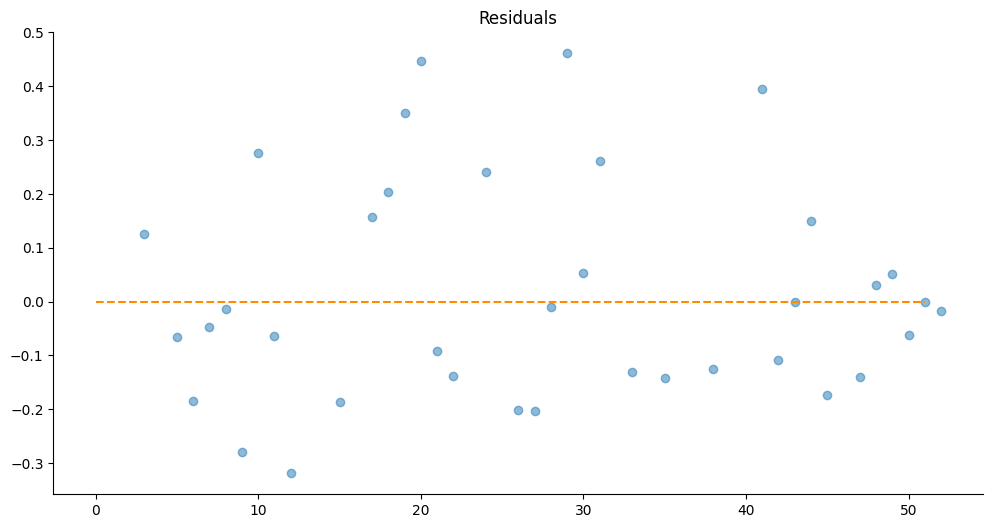

In [37]:
linear_assumption(ml, var[['X11', 'X10']], var["X7"])
normal_errors_assumption(ml, var[['X11', 'X10']], var["X7"])
multicollinearity_assumption(ml, var[['X11', 'X10']], var["X7"], ['X11', 'X10'])
autocorrelation_assumption(ml, var[['X11', 'X10']], var["X7"])
homoscedasticity_assumption(ml, var[['X11', 'X10']], var["X7"])

Este modelo en cambio ya falla con una de las assumptions

# Cierre
Rápidamente se puede ver con la exploración que estuvimos haciendo que la respuesta a la preugnta e sque los factores importantes son x9, x10 y x11 pero que el modelo se desempeña mucho mejor cuando se incluye a todas las variables, lo que sí considero es que la X12 esa no debería incluirse. Aún así con esas 3 varíables la R2 es muy cercana al modelo que incluye a todas las variables.


# Otra duda  

Es la concentración dañina  (límite es 0.5 mg de Hg/kg ya traducido a ppm es .5ppm)

In [44]:
# H0: µ > .5 (the mean mercury ppm for the lakes is .5ppm) - concentración dañina
# HA: µ <= .5 (the mean mercury ppm for the lakes is .5ppm)

import scipy.stats as stats

#perform one sample t-test
print("mean", df["X7"].mean())
stats.ttest_1samp(a=df["X7"], popmean=.5, alternative='greater')


0.5271698113207547


Ttest_1sampResult(statistic=0.5799957469974558, pvalue=0.2822111415088424)

Esta prueba la hago sobre el dataset sin procesar.. y podemos decir que la concnetración de los lagos es dañina y por eso no rechzamos H0, estamos considerando que significancia de pvalue es .05

# Validation 

In [38]:
data = var
X = data.drop(columns=["X1", "X2", "X7"])
y = data["X7"]

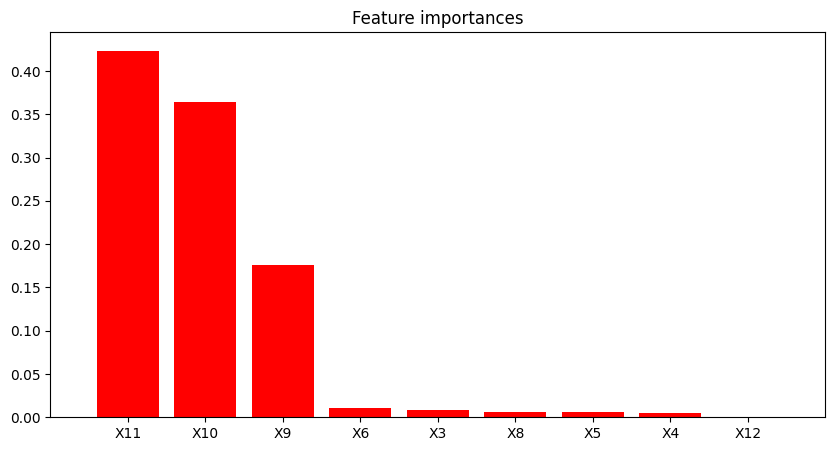

In [39]:
sel = SelectFromModel(RandomForestRegressor(n_estimators = 1000))
sel.fit(X, y)

importances = sel.estimator_.feature_importances_
names = sel.estimator_.feature_names_in_

indices = np.argsort(importances)[::-1]
# X is the train data used to fit the model 
plt.figure(figsize=(10,5))
plt.title("Feature importances")
plt.bar(range(X.shape[1]), importances[indices], color="r", align="center")
plt.xticks(range(X.shape[1]), [names[i] for i in indices])
plt.xlim([-1, X.shape[1]])
plt.show()